# cuda:7

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
torch.set_num_threads(4)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:7'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)
print(f'\nsignal mean={np.mean(signal)}')
M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST

SIGNUM = 2      
MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M = {M}')
print(f'minmax = {MINMAX}')
print(f'std = {STD}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0

signal mean=-6.580979147873308e-17
Signal Length M = 20000
minmax = 1.611402028919085
std = 0.3429382374043401


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

def compute_rank(a, g, wr, wi, n, k):
    tols = [1/10**x for x in range(0,20)]
    x0 = np.zeros((n,1))
    u0 = np.zeros((k,1))
    A = rca.leaky_jacobian(x0, u0, a, g, wi, wr)
    B = rca.partial_u(x0, u0, a, g, wi, wr)
    Cn = rca.reachable_matrix(A,B)
    nan_flag = np.isnan(Cn).any()
    inf_flag = np.isinf(Cn).any()
    print(f'NaN present {nan_flag}\t inf present {inf_flag}\n')
    Cn = np.nan_to_num(rca.reachable_matrix(A,B), nan=1)
    if(SIGNUM != 3): # Square Cn
        Cn = Cn/np.abs(np.max(np.linalg.eigvals(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.abs(np.max(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Ave rank for N={n} is {ave_rank}')
    return ave_rank

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [4]:
min_a, max_a = .4,.6      # .2, .4
min_sr, max_sr = 1., 1.2    # 5., 6.5
min_g, max_g = .3, .4     # .2, .4
min_ri, max_ri = .3, .4   # .001, 5.
min_rr, max_rr = 1., 3.     # .001, 5.
space = [Real(min_a, max_a, name='a'),
         Real(min_sr, max_sr, name='sr'), 
         Real(min_ri, max_ri, name='ri'),
         Real(min_rr, max_rr, name='rr')
        ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,ri=1.0,rr=1.0):
    start = time.time()
    amp=1.0
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales, dict_model, \
           model_counter, error_per_N, error_over_N, best_N_model
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) and (nrmse < .1)):
        print(f'Dist {dist:3f}')
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        if(error_over_N > running_error):
            print('\n\nNew N best!!!!!!!!!!!!\n\n')
            error_over_N = running_error  #set the lowest error
            best_N_model = [N,ref,rn,counter]
            states_dict = {'States': state}
            with open(f'Dicts/States/states_MG_{N}.json', 'w') as fp:
                json.dump(states_dict, fp, cls=NumpyArrayEncoder)
            dict_model[str(N)] = {'Wnet': wnet,
                                  'Wout': wout,
                                  'Preds': yHat_GPU,
                                  'Params': currentParams}
            print(best_N_model)
            
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        plt.close()
        model_counter += 1
        error_per_N.append(nrmse)
        
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Time {(time.time()-start):.2f}',
          f' NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N),axis=0).tolist(),
                             'varError' : np.var(np.array(error_per_N),axis=0).tolist()}
    counter += 1
    return loss


********** Size24 ref 0 -- Run 0 ***********
Iter: 0 #### Time 9.44  NRMSE 1000.000 CD nan
Iter: 1 #### Time 6.24  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.87  NRMSE 0.270 CD 1.349
Iter: 3 #### Time 5.68  NRMSE 0.981 CD 0.974
Iter: 4 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 5 #### Time 5.89  NRMSE 0.205 CD 0.619
Iter: 6 #### Time 5.90  NRMSE 0.396 CD 1.061
Iter: 7 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 8 #### Time 5.72  NRMSE 212074080.615 CD 0.877
Iter: 9 #### Time 6.01  NRMSE 1000.000 CD nan
Iter: 10 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 11 #### Time 5.79  NRMSE 0.349 CD 1.341
Iter: 12 #### Time 5.67  NRMSE 0.223 CD 0.831
Iter: 13 #### Time 6.01  NRMSE 0.243 CD 0.745
Iter: 14 #### Time 6.22  NRMSE 1000.000 CD nan
Iter: 15 #### Time 6.26  NRMSE 0.218 CD 0.793
Iter: 16 #### Time 6.06  NRMSE 0.152 CD 0.355
Iter: 17 #### Time 5.92  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 19 #### Time 6.07  NRMSE 0.357 CD 1.297
Iter: 20 #### Time 6.18  NRM

Iter: 71 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 72 #### Time 7.07  NRMSE 1000.000 CD nan
Iter: 73 #### Time 6.26  NRMSE 1000.000 CD nan
Iter: 74 #### Time 6.02  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.96  NRMSE 0.244 CD 1.086
Iter: 76 #### Time 6.07  NRMSE 1000.000 CD nan
Iter: 77 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 78 #### Time 6.09  NRMSE 1000.000 CD nan
Iter: 79 #### Time 6.40  NRMSE 0.148 CD 0.319
Iter: 80 #### Time 6.24  NRMSE 0.160 CD 0.398
Iter: 81 #### Time 6.15  NRMSE 0.208 CD 0.794
Iter: 82 #### Time 5.99  NRMSE 0.265 CD 1.002
Iter: 83 #### Time 5.73  NRMSE 0.241 CD 1.230
Iter: 84 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.68  NRMSE 0.264 CD 0.972
Iter: 86 #### Time 5.56  NRMSE 0.339 CD 1.255
Iter: 87 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 88 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.61  NRMSE 0.391 CD 1.306
Iter: 91 #### Time 5.52  NRMSE 0.302 CD 1.071
Iter: 92 #### Time 5.53

Iter: 39 #### Time 5.81  NRMSE 1000.000 CD nan
Iter: 40 #### Time 5.63  NRMSE 0.213 CD 0.686
Iter: 41 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 43 #### Time 5.68  NRMSE 0.369 CD 0.912
Iter: 44 #### Time 5.62  NRMSE 0.270 CD 0.925
Iter: 45 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.74  NRMSE 0.278 CD 1.025
Iter: 47 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 48 #### Time 5.58  NRMSE 0.288 CD 1.060
Iter: 49 #### Time 5.58  NRMSE 0.336 CD 1.056
Iter: 50 #### Time 5.83  NRMSE 0.247 CD 0.862
Iter: 51 #### Time 5.70  NRMSE 0.316 CD 1.178
Iter: 52 #### Time 5.69  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.79  NRMSE 0.267 CD 0.666
Iter: 55 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.71  NRMSE 0.313 CD 1.212
Iter: 60 #### Time 5.84

Iter: 3 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 4 #### Time 5.72  NRMSE 1000.000 CD nan
Iter: 5 #### Time 5.75  NRMSE 0.263 CD 0.822
Iter: 6 #### Time 5.72  NRMSE 0.275 CD 0.924
Iter: 7 #### Time 5.68  NRMSE 0.206 CD 0.730
Iter: 8 #### Time 5.68  NRMSE 1000.000 CD nan
Iter: 9 #### Time 5.60  NRMSE 0.200 CD 0.768
Iter: 10 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 11 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 12 #### Time 5.63  NRMSE 0.245 CD 0.879
Iter: 13 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 14 #### Time 5.55  NRMSE 0.211 CD 0.538
Iter: 15 #### Time 5.53  NRMSE 15151252641375434865448549613568.000 CD 1.000
Iter: 16 #### Time 5.56  NRMSE 0.235 CD 0.704
Iter: 17 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.79  NRMSE 0.189 CD 0.682
Iter: 19 #### Time 5.80  NRMSE 0.180 CD 0.554
Iter: 20 #### Time 5.80  NRMSE 0.250 CD 0.849
Iter: 21 #### Time 5.69  NRMSE 0.215 CD 0.468
Iter: 22 #### Time 5.64  NRMSE 0.270 CD 0.757
Iter: 23 #### Time 5.76  NRMSE 0.258 CD 0.842
Ite

Iter: 74 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 76 #### Time 5.77  NRMSE 0.188 CD 0.671
Iter: 77 #### Time 6.02  NRMSE 0.295 CD 1.204
Iter: 78 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 83 #### Time 5.98  NRMSE 0.199 CD 0.826
Iter: 84 #### Time 6.10  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 87 #### Time 6.08  NRMSE 0.242 CD 1.012
Iter: 88 #### Time 5.92  NRMSE 1000.000 CD nan
Iter: 89 #### Time 6.29  NRMSE 1000.000 CD nan
Iter: 90 #### Time 6.26  NRMSE 0.250 CD 1.000
Iter: 91 #### Time 6.08  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.98  NRMSE 0.349 CD 1.180
Iter: 93 #### Time 6.06  NRMSE 1000.000 CD nan
Iter: 94 #### Time 6.05  NRMSE 1000.000 CD nan
Iter: 95 #### Time 

Iter: 40 #### Time 6.19  NRMSE 0.261 CD 1.059
Iter: 41 #### Time 6.07  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.75  NRMSE 0.213 CD 0.825
Iter: 43 #### Time 5.89  NRMSE 0.344 CD 1.053
Iter: 44 #### Time 5.80  NRMSE 0.183 CD 0.597
Iter: 45 #### Time 5.92  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 47 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 48 #### Time 5.68  NRMSE 1000.000 CD nan
Iter: 49 #### Time 5.96  NRMSE 0.268 CD 0.936
Iter: 50 #### Time 6.98  NRMSE 0.214 CD 1.031
Iter: 51 #### Time 6.23  NRMSE 0.254 CD 0.930
Iter: 52 #### Time 6.01  NRMSE 0.213 CD 0.815
Iter: 53 #### Time 5.78  NRMSE 9590522621.602 CD 1.128
Iter: 54 #### Time 5.79  NRMSE 0.283 CD 0.598
Iter: 55 #### Time 5.87  NRMSE 0.179 CD 0.549
Iter: 56 #### Time 5.93  NRMSE 1000.000 CD nan
Iter: 57 #### Time 6.26  NRMSE 1000.000 CD nan
Iter: 58 #### Time 6.00  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.78  NRMSE 0.246 CD 0.742
Iter: 60 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 61 #### Ti

Iter: 5 #### Time 6.19  NRMSE 0.110 CD 0.164
Iter: 6 #### Time 5.88  NRMSE 0.246 CD 0.814
Iter: 7 #### Time 5.95  NRMSE 0.250 CD 1.089
Iter: 8 #### Time 5.80  NRMSE 0.200 CD 0.728
Iter: 9 #### Time 5.79  NRMSE 0.295 CD 1.074
Iter: 10 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 11 #### Time 5.92  NRMSE 0.280 CD 0.953
Iter: 12 #### Time 6.02  NRMSE 0.318 CD 1.316
Iter: 13 #### Time 5.90  NRMSE 0.307 CD 1.134
Iter: 14 #### Time 5.90  NRMSE 0.337 CD 1.253
Iter: 15 #### Time 5.83  NRMSE 0.230 CD 0.755
Iter: 16 #### Time 5.91  NRMSE 0.211 CD 0.769
Iter: 17 #### Time 6.14  NRMSE 0.249 CD 0.779
Iter: 18 #### Time 6.08  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.99  NRMSE 0.205 CD 0.878
Iter: 20 #### Time 5.83  NRMSE 0.305 CD 1.255
Iter: 21 #### Time 5.80  NRMSE 0.280 CD 1.217
Iter: 22 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.80  NRMSE 0.196 CD 0.489
Iter: 25 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.95  NRMSE 100

Iter: 78 #### Time 5.81  NRMSE 0.182 CD 0.599
Iter: 79 #### Time 5.81  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.71  NRMSE 0.339 CD 1.395
Iter: 81 #### Time 5.80  NRMSE 0.210 CD 0.861
Iter: 82 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 83 #### Time 5.64  NRMSE 0.276 CD 0.906
Iter: 84 #### Time 5.73  NRMSE 0.311 CD 1.325
Iter: 85 #### Time 5.81  NRMSE 0.155 CD 0.361
Iter: 86 #### Time 5.71  NRMSE 0.194 CD 0.757
Iter: 87 #### Time 5.69  NRMSE 0.213 CD 0.763
Iter: 88 #### Time 5.69  NRMSE 0.197 CD 0.463
Iter: 89 #### Time 5.83  NRMSE 0.283 CD 1.083
Iter: 90 #### Time 5.70  NRMSE 0.271 CD 0.865
Iter: 91 #### Time 5.69  NRMSE 0.199 CD 0.756
Iter: 92 #### Time 5.72  NRMSE 4180655939467.335 CD 1.100
Iter: 93 #### Time 5.66  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 95 #### Time 5.91  NRMSE 0.253 CD 0.733
Iter: 96 #### Time 5.70  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.64  NRMSE 0.231 CD 1.054
Iter: 98 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 99 #### Ti

Iter: 44 #### Time 5.76  NRMSE 0.196 CD 0.760
Iter: 45 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 46 #### Time 6.09  NRMSE 1000.000 CD nan
Iter: 47 #### Time 6.09  NRMSE 0.297 CD 1.081
Iter: 48 #### Time 6.00  NRMSE 0.308 CD 1.138
Iter: 49 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 50 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 51 #### Time 6.00  NRMSE 0.158 CD 0.389
Iter: 52 #### Time 6.82  NRMSE 1000.000 CD nan
Iter: 53 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 54 #### Time 6.03  NRMSE 1000.000 CD nan
Iter: 55 #### Time 6.22  NRMSE 1000.000 CD nan
Iter: 56 #### Time 7.18  NRMSE 0.175 CD 0.519
Iter: 57 #### Time 5.98  NRMSE 0.249 CD 1.246
Iter: 58 #### Time 6.04  NRMSE 0.305 CD 1.176
Iter: 59 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 60 #### Time 6.02  NRMSE 1000.000 CD nan
Iter: 61 #### Time 6.50  NRMSE 1000.000 CD nan
Iter: 62 #### Time 6.50  NRMSE 0.211 CD 0.928
Iter: 63 #### Time 6.13  NRMSE 0.336 CD 1.357
Iter: 64 #### Time 6.09  NRMSE 1000.000 CD nan
Iter: 65 #### Time 5.8

Iter: 9 #### Time 6.12  NRMSE 0.248 CD 0.903
Iter: 10 #### Time 5.94  NRMSE 0.146 CD 0.299
Iter: 11 #### Time 6.38  NRMSE 1000.000 CD nan
Iter: 12 #### Time 6.76  NRMSE 0.176 CD 0.507
Iter: 13 #### Time 6.72  NRMSE 1000.000 CD nan
Iter: 14 #### Time 6.21  NRMSE 1000.000 CD nan
Iter: 15 #### Time 6.00  NRMSE 1000.000 CD nan
Iter: 16 #### Time 7.29  NRMSE 1000.000 CD nan
Iter: 17 #### Time 6.06  NRMSE 0.248 CD 0.725
Iter: 18 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 19 #### Time 6.10  NRMSE 0.161 CD 0.412
Iter: 20 #### Time 6.81  NRMSE 1000.000 CD nan
Iter: 21 #### Time 6.27  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.89  NRMSE 1000.000 CD nan
Iter: 23 #### Time 6.52  NRMSE 1000.000 CD nan
Iter: 24 #### Time 6.57  NRMSE 0.268 CD 1.139
Iter: 25 #### Time 6.38  NRMSE 0.305 CD 1.112
Iter: 26 #### Time 6.32  NRMSE 0.202 CD 0.839
Iter: 27 #### Time 6.46  NRMSE 1000.000 CD nan
Iter: 28 #### Time 6.46  NRMSE 0.258 CD 0.866
Iter: 29 #### Time 6.46  NRMSE 0.346 CD 1.071
Iter: 30 #### Time 5.90 

Iter: 82 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 83 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.66  NRMSE 0.328 CD 1.193
Iter: 87 #### Time 5.69  NRMSE 0.252 CD 1.130
Iter: 88 #### Time 5.96  NRMSE 0.197 CD 0.775
Iter: 89 #### Time 5.72  NRMSE 1.836 CD 1.026
Iter: 90 #### Time 5.72  NRMSE 0.337 CD 1.105
Iter: 91 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.68  NRMSE 0.279 CD 0.794
Iter: 93 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.84  NRMSE 0.268 CD 1.075
Iter: 95 #### Time 5.71  NRMSE 0.191 CD 0.707
Iter: 96 #### Time 5.74  NRMSE 0.312 CD 1.137
Iter: 97 #### Time 5.79  NRMSE 0.231 CD 0.895
Iter: 98 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.81  NRMSE 1000.000 CD nan
End Run 1 Time 616.961

Best result = 0.4890064404059794
a = 0.48735930861626925
sr = 1.095881547398856
amp = 0.30582542546553726
ri = 1.728639211755485
********** 

Iter: 50 #### Time 5.88  NRMSE 0.289 CD 1.173
Iter: 51 #### Time 5.74  NRMSE 360.495 CD 1.114
Iter: 52 #### Time 5.77  NRMSE 0.186 CD 0.441
Iter: 53 #### Time 5.78  NRMSE 0.250 CD 1.029
Iter: 54 #### Time 5.77  NRMSE 0.224 CD 0.763
Iter: 55 #### Time 5.75  NRMSE 0.302 CD 1.045
Iter: 56 #### Time 5.92  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.76  NRMSE 0.217 CD 0.928
Iter: 58 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.80  NRMSE 14148239279255603210254024704.000 CD 1.000
Iter: 60 #### Time 6.14  NRMSE 0.220 CD 0.900
Iter: 61 #### Time 5.91  NRMSE 558792213007640628159480787369984.000 CD 1.000
Iter: 62 #### Time 5.83  NRMSE 0.183 CD 0.527
Iter: 63 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.83  NRMSE 0.223 CD 0.490
Iter: 65 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 66 #### Time 5.80  NRMSE 0.178 CD 0.394
Iter: 67 #### Time 5.86  NRMSE 0.370 CD 1.254
Iter: 68 #### Time 6.02  NRMSE 2715.267 CD 1.102
Iter: 69 #### Time 5.81  NRMSE 925.688 CD 0.865
Iter: 70 

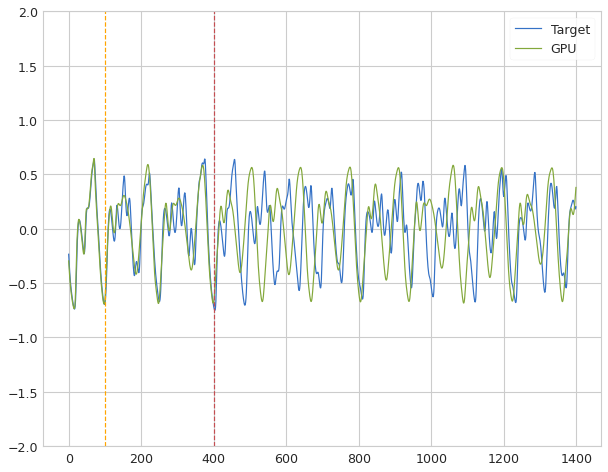

 Iter=65 a=0.403 sr=1.042 amp=1.000  ri=0.305 rr=2.920 loss=0.150905
Iter: 65 #### Time 6.83  NRMSE 0.077 CD 0.074
Iter: 66 #### Time 5.86  NRMSE 0.176 CD 0.507
Iter: 67 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 68 #### Time 5.76  NRMSE 0.188 CD 0.666
Iter: 69 #### Time 5.82  NRMSE 0.190 CD 0.478
Iter: 70 #### Time 5.74  NRMSE 0.279 CD 1.313
Iter: 71 #### Time 5.74  NRMSE 0.183 CD 0.609
Iter: 72 #### Time 5.90  NRMSE 0.228 CD 0.789
Iter: 73 #### Time 5.76  NRMSE 4105720683.448 CD 1.135
Iter: 74 #### Time 5.84  NRMSE 0.211 CD 0.832
Iter: 75 #### Time 5.89  NRMSE 0.290 CD 1.012
Iter: 76 #### Time 5.84  NRMSE 0.198 CD 0.511
Iter: 77 #### Time 5.80  NRMSE 0.245 CD 0.912
Iter: 78 #### Time 5.81  NRMSE 0.220 CD 0.837
Iter: 79 #### Time 5.76  NRMSE 0.183 CD 0.603
Iter: 80 #### Time 5.82  NRMSE 0.186 CD 0.640
Iter: 81 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.76  NRMSE 0.220 CD 0.771
Iter: 83 #### Time 5.78  NRMSE 0.219 CD 0.532
Iter: 84 #### Time 5.77  NRMSE 0.316 CD 0.896


Iter: 19 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.89  NRMSE 1000.000 CD nan
Iter: 21 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.94  NRMSE 0.213 CD 0.558
Iter: 24 #### Time 6.17  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.95  NRMSE 0.281 CD 0.945
Iter: 27 #### Time 5.77  NRMSE 0.244 CD 0.660
Iter: 28 #### Time 5.88  NRMSE 0.216 CD 0.716
Iter: 29 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 30 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 31 #### Time 6.28  NRMSE 0.199 CD 0.814
Iter: 32 #### Time 6.62  NRMSE 0.181 CD 0.583
Iter: 33 #### Time 6.30  NRMSE 1000.000 CD nan
Iter: 34 #### Time 6.23  NRMSE 1000.000 CD nan
Iter: 35 #### Time 6.13  NRMSE 0.241 CD 0.706
Iter: 36 #### Time 6.22  NRMSE 124.104 CD 0.885
Iter: 37 #### Time 6.11  NRMSE 1000.000 CD nan
Iter: 38 #### Time 6.33  NRMSE 1000.000 CD nan
Iter: 39 #### Time 6.44  NRMSE 1000.000 CD nan
Iter: 40 #### Time 

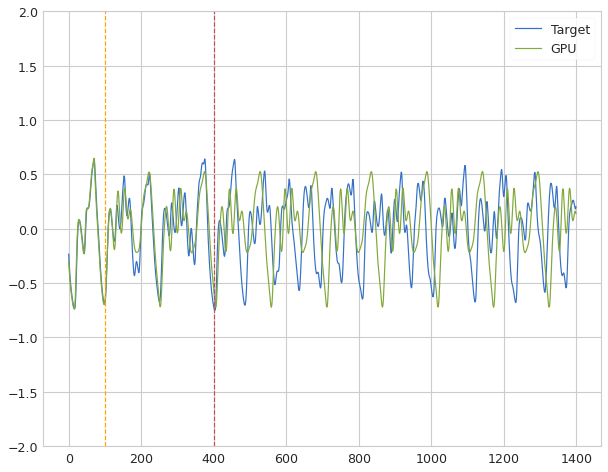

 Iter=13 a=0.568 sr=1.139 amp=1.000  ri=0.345 rr=1.725 loss=0.221679
Iter: 13 #### Time 6.17  NRMSE 0.096 CD 0.125
Iter: 14 #### Time 5.79  NRMSE 0.215 CD 0.551
Iter: 15 #### Time 5.96  NRMSE 1000.000 CD nan
Iter: 16 #### Time 5.75  NRMSE 0.192 CD 0.529
Iter: 17 #### Time 5.81  NRMSE 0.214 CD 0.842
Iter: 18 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.77  NRMSE 0.353 CD 1.018
Iter: 20 #### Time 5.81  NRMSE 0.162 CD 0.345
Iter: 21 #### Time 5.83  NRMSE 0.353 CD 1.451
Iter: 22 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.76  NRMSE 0.238 CD 1.112
Iter: 26 #### Time 5.78  NRMSE 0.212 CD 0.909
Iter: 27 #### Time 6.28  NRMSE 1000.000 CD nan
Iter: 28 #### Time 5.77  NRMSE 0.155 CD 0.365
Iter: 29 #### Time 5.85  NRMSE 0.267 CD 0.978
Iter: 30 #### Time 5.89  NRMSE 1000.000 CD nan
Iter: 31 #### Time 5.93  NRMSE 0.309 CD 1.095
Iter: 32 #### Time 5.85  NRMSE 0.182 CD 0.588
Iter

Iter: 84 #### Time 5.79  NRMSE 0.190 CD 0.532
Iter: 85 #### Time 5.71  NRMSE 0.207 CD 0.819
Iter: 86 #### Time 5.70  NRMSE 0.180 CD 0.563
Iter: 87 #### Time 5.79  NRMSE 27.152 CD 1.031
Iter: 88 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.73  NRMSE 0.274 CD 1.167
Iter: 90 #### Time 6.09  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.70  NRMSE 0.211 CD 0.683
Iter: 92 #### Time 5.74  NRMSE 0.206 CD 0.925
Iter: 93 #### Time 5.88  NRMSE 153511838776608.469 CD 0.813
Iter: 94 #### Time 5.83  NRMSE 0.317 CD 1.233
Iter: 95 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.77  NRMSE 0.208 CD 0.815
Iter: 97 #### Time 5.73  NRMSE 0.308 CD 1.112
Iter: 98 #### Time 5.81  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.74  NRMSE 0.297 CD 1.104
End Run 3 Time 616.526

Best result = 0.24898445786144013
a = 0.5645699762744414
sr = 1.0878085407629754
amp = 0.3311218577819066
ri = 2.982178290765111
********** Size24 ref 4 -- Run 4 ***********
Iter: 0 #### Time 6.37  NRMSE 1000.000 CD nan
I

Iter: 38 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.97  NRMSE 0.153 CD 0.338
Iter: 40 #### Time 5.93  NRMSE 0.364 CD 0.752
Iter: 41 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.74  NRMSE 0.307 CD 1.175
Iter: 43 #### Time 5.80  NRMSE 7.732 CD 1.012
Iter: 44 #### Time 5.83  NRMSE 0.200 CD 0.715
Iter: 45 #### Time 5.84  NRMSE 0.267 CD 0.930
Iter: 46 #### Time 5.74  NRMSE 0.219 CD 0.731
Iter: 47 #### Time 5.78  NRMSE 0.233 CD 0.964
Iter: 48 #### Time 5.76  NRMSE 0.191 CD 0.710
Iter: 49 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.87  NRMSE 0.222 CD 0.841
Iter: 52 #### Time 5.86  NRMSE 0.291 CD 1.257
Iter: 53 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.76  NRMSE 0.302 CD 1.206
Iter: 55 #### Time 5.77  NRMSE 0.185 CD 0.620
Iter: 56 #### Time 6.07  NRMSE 1000.000 CD nan
Iter: 57 #### Time 6.51  NRMSE 0.197 CD 0.794
Iter: 58 #### Time 5.87  NRMSE 0.230 CD 0.805
Iter: 59 #### Time 5.91  NRM

Iter: 5 #### Time 5.99  NRMSE 1000.000 CD nan
Iter: 6 #### Time 6.45  NRMSE 0.276 CD 1.019
Iter: 7 #### Time 6.34  NRMSE 0.239 CD 0.984
Iter: 8 #### Time 6.05  NRMSE 1000.000 CD nan
Iter: 9 #### Time 6.25  NRMSE 0.231 CD 1.106
Iter: 10 #### Time 5.91  NRMSE 1000.000 CD nan
Iter: 11 #### Time 6.63  NRMSE 1000.000 CD nan
Iter: 12 #### Time 5.95  NRMSE 0.206 CD 0.822
Iter: 13 #### Time 5.91  NRMSE 0.248 CD 1.027
Iter: 14 #### Time 6.46  NRMSE 0.273 CD 0.865
Iter: 15 #### Time 6.18  NRMSE 0.202 CD 0.798
Iter: 16 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 17 #### Time 5.94  NRMSE 0.213 CD 0.424
Iter: 18 #### Time 6.35  NRMSE 0.250 CD 0.925
Iter: 19 #### Time 6.14  NRMSE 0.248 CD 0.972
Iter: 20 #### Time 6.81  NRMSE 0.216 CD 1.035
Iter: 21 #### Time 6.66  NRMSE 1000.000 CD nan
Iter: 22 #### Time 6.07  NRMSE 0.330 CD 1.188
Iter: 23 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 24 #### Time 6.51  NRMSE 1000.000 CD nan
Iter: 25 #### Time 6.31  NRMSE 0.331 CD 1.219
Iter: 26 #### Time 6.03  NRMSE 

Iter: 76 #### Time 6.39  NRMSE 0.248 CD 1.049
Iter: 77 #### Time 6.17  NRMSE 1000.000 CD nan
Iter: 78 #### Time 6.08  NRMSE 1000.000 CD nan
Iter: 79 #### Time 6.13  NRMSE 0.324 CD 1.016
Iter: 80 #### Time 6.50  NRMSE 0.216 CD 0.915
Iter: 81 #### Time 6.21  NRMSE 0.173 CD 0.505
Iter: 82 #### Time 5.85  NRMSE 0.219 CD 0.832
Iter: 83 #### Time 6.65  NRMSE 1000.000 CD nan
Iter: 84 #### Time 6.49  NRMSE 0.283 CD 1.141
Iter: 85 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 86 #### Time 6.51  NRMSE 0.307 CD 1.163
Iter: 87 #### Time 6.19  NRMSE 0.314 CD 1.145
Iter: 88 #### Time 5.83  NRMSE 0.211 CD 0.804
Iter: 89 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.81  NRMSE 0.229 CD 1.028
Iter: 92 #### Time 6.24  NRMSE 0.186 CD 0.642
Iter: 93 #### Time 5.81  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.99  NRMSE 0.208 CD 0.837
Iter: 95 #### Time 5.82  NRMSE 0.251 CD 1.137
Iter: 96 #### Time 5.81  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.76  N

Iter: 39 #### Time 6.02  NRMSE 1000.000 CD nan
Iter: 40 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.70  NRMSE 0.190 CD 0.698
Iter: 43 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 44 #### Time 5.72  NRMSE 0.224 CD 0.659
Iter: 45 #### Time 5.72  NRMSE 0.280 CD 1.081
Iter: 46 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 47 #### Time 6.11  NRMSE 1000.000 CD nan
Iter: 48 #### Time 5.90  NRMSE 9.786 CD 1.100
Iter: 49 #### Time 5.85  NRMSE 0.196 CD 0.653
Iter: 50 #### Time 5.74  NRMSE 0.252 CD 1.166
Iter: 51 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.80  NRMSE 0.201 CD 0.550
Iter: 53 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 54 #### Time 6.24  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.81  NRMSE 0.304 CD 1.105
Iter: 58 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.91  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.

Iter: 7 #### Time 5.56  NRMSE 0.213 CD 0.717
Iter: 8 #### Time 5.53  NRMSE 0.313 CD 1.243
Iter: 9 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 10 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 11 #### Time 5.50  NRMSE 0.366 CD 1.528
Iter: 12 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.51  NRMSE 0.297 CD 1.049
Iter: 14 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 15 #### Time 5.48  NRMSE 0.207 CD 0.571
Iter: 16 #### Time 5.54  NRMSE 0.191 CD 0.705
Iter: 17 #### Time 5.47  NRMSE 0.171 CD 0.472
Iter: 18 #### Time 5.48  NRMSE 0.168 CD 0.351
Iter: 19 #### Time 5.66  NRMSE 0.198 CD 0.766
Iter: 20 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 21 #### Time 5.50  NRMSE 0.272 CD 0.963
Iter: 22 #### Time 5.63  NRMSE 0.301 CD 0.710
Iter: 23 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 27 #### Time 6.01  NRMSE 0.231 CD 0.744
Iter: 28 #### Time 5.87  NRM

Iter: 78 #### Time 6.22  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.81  NRMSE 0.190 CD 0.688
Iter: 80 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.89  NRMSE 0.217 CD 0.909
Iter: 82 #### Time 6.11  NRMSE 1000.000 CD nan
Iter: 83 #### Time 6.14  NRMSE 0.189 CD 0.684
Iter: 84 #### Time 5.80  NRMSE 0.267 CD 0.873
Iter: 85 #### Time 5.94  NRMSE 0.259 CD 0.867
Iter: 86 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 87 #### Time 5.69  NRMSE 0.281 CD 1.012
Iter: 88 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 89 #### Time 6.34  NRMSE 0.283 CD 1.061
Iter: 90 #### Time 6.28  NRMSE 1000.000 CD nan
Iter: 91 #### Time 7.24  NRMSE 0.188 CD 0.666
Iter: 92 #### Time 5.83  NRMSE 0.197 CD 0.791
Iter: 93 #### Time 5.69  NRMSE 0.245 CD 0.924
Iter: 94 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 95 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.91  NRMSE 0.197 CD 0.754
Iter: 97 #### Time 5.79  NRMSE 0.195 CD 0.441
Iter: 98 #### Time 5.74  NRMSE 0.299 CD 1.095
Iter: 99 #### Time 6.13  N

Iter: 43 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 44 #### Time 5.93  NRMSE 1000.000 CD nan
Iter: 45 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 46 #### Time 6.26  NRMSE 1000.000 CD nan
Iter: 47 #### Time 5.78  NRMSE 0.246 CD 1.044
Iter: 48 #### Time 5.66  NRMSE 0.356 CD 1.037
Iter: 49 #### Time 6.29  NRMSE 1000.000 CD nan
Iter: 50 #### Time 6.28  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.66  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.54  NRMSE 0.264 CD 0.980
Iter: 53 #### Time 5.52  NRMSE 0.279 CD 1.056
Iter: 54 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.55  NRMSE 0.196 CD 0.766
Iter: 56 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.56  NRMSE 0.191 CD 0.709
Iter: 58 #### Time 5.56  NRMSE 0.196 CD 0.734
Iter: 59 #### Time 5.52  NRMSE 0.320 CD 1.317
Iter: 60 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 61 #### Time 5.51  NRMSE 0.310 CD 1.186
Iter: 62 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.5

Iter: 11 #### Time 5.53  NRMSE 47450.708 CD 0.866
Iter: 12 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.54  NRMSE 0.289 CD 1.118
Iter: 14 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 15 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 16 #### Time 5.79  NRMSE 0.249 CD 1.201
Iter: 17 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.56  NRMSE 0.339 CD 1.281
Iter: 21 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.56  NRMSE 0.258 CD 0.964
Iter: 23 #### Time 5.54  NRMSE 0.196 CD 0.442
Iter: 24 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.54  NRMSE 0.224 CD 0.844
Iter: 27 #### Time 5.49  NRMSE 0.248 CD 1.183
Iter: 28 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.45  NRMSE 0.272 CD 0.935
Iter: 30 #### Time 5.45  NRMSE 0.266 CD 1.086
Iter: 31 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 32 #### Time 

Iter: 83 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.52  NRMSE 0.287 CD 1.109
Iter: 85 #### Time 5.52  NRMSE 0.271 CD 0.899
Iter: 86 #### Time 5.49  NRMSE 0.233 CD 0.851
Iter: 87 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 88 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.54  NRMSE 0.273 CD 0.529
Iter: 90 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.51  NRMSE 0.196 CD 0.768
Iter: 93 #### Time 5.49  NRMSE 0.184 CD 0.620
Iter: 94 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 95 #### Time 5.52  NRMSE 80197294531596905811684773733597184.000 CD 1.000
Iter: 96 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.96  NRMSE 0.190 CD 0.697
Iter: 98 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 99 #### Time 6.11  NRMSE 1000.000 CD nan
End Run 3 Time 565.986

Best result = 0.5335809654019823
a = 0.4391992735241582
sr = 1.0904535695831057
amp = 0.30448622842221057
ri = 2.275266757086264
********** Size22 ref 

Iter: 48 #### Time 5.84  NRMSE 0.231 CD 0.936
Iter: 49 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.75  NRMSE 0.255 CD 0.684
Iter: 51 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.95  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.79  NRMSE 0.266 CD 1.149
Iter: 55 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.77  NRMSE 0.235 CD 1.115
Iter: 57 #### Time 5.79  NRMSE 0.278 CD 1.179
Iter: 58 #### Time 5.79  NRMSE 0.196 CD 0.784
Iter: 59 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.83  NRMSE 0.291 CD 0.967
Iter: 61 #### Time 5.91  NRMSE 0.252 CD 0.867
Iter: 62 #### Time 5.95  NRMSE 0.206 CD 0.855
Iter: 63 #### Time 5.99  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 65 #### Time 6.09  NRMSE 0.232 CD 1.021
Iter: 66 #### Time 5.70  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.79  NRMSE 0.200 CD 0.761
Iter: 68 #### Time 6.03  NRMSE 1000.000 CD nan
Iter: 69 #### Time 6.06 

Iter: 17 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.97  NRMSE 0.270 CD 1.179
Iter: 19 #### Time 5.89  NRMSE 0.343 CD 1.231
Iter: 20 #### Time 5.71  NRMSE 167.285 CD 0.889
Iter: 21 #### Time 5.77  NRMSE 0.202 CD 0.656
Iter: 22 #### Time 5.76  NRMSE 26.490 CD 0.978
Iter: 23 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.70  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.89  NRMSE 0.303 CD 1.127
Iter: 27 #### Time 6.19  NRMSE 0.267 CD 1.197
Iter: 28 #### Time 5.98  NRMSE 0.159 CD 0.381
Iter: 29 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 30 #### Time 6.07  NRMSE 0.178 CD 0.494
Iter: 31 #### Time 5.73  NRMSE 0.261 CD 1.141
Iter: 32 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.51  NRMSE 0.309 CD 1.098
Iter: 34 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.55  NRMSE 0.210 CD 0.676
Iter: 38 #### Time 5.5

Iter: 89 #### Time 5.46  NRMSE 0.311 CD 1.050
Iter: 90 #### Time 5.52  NRMSE 0.198 CD 0.667
Iter: 91 #### Time 5.46  NRMSE 0.247 CD 0.672
Iter: 92 #### Time 5.55  NRMSE 0.270 CD 1.043
Iter: 93 #### Time 5.50  NRMSE 0.282 CD 0.975
Iter: 94 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 95 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.59  NRMSE 0.207 CD 0.883
Iter: 97 #### Time 5.46  NRMSE 0.178 CD 0.536
Iter: 98 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.55  NRMSE 0.333 CD 1.246
End Run 3 Time 575.884

Best result = 0.3411560055410526
a = 0.45888676151560553
sr = 1.010570923983853
amp = 0.33174882249539145
ri = 2.967898538128382
********** Size22 ref 3 -- Run 4 ***********
Iter: 0 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.70  NRMSE 0.220 CD 0.895
Iter: 4 #### Time 5.52  NRMSE 0.340 CD 1.224
Iter: 5 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 6 #### Time 5

Iter: 53 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.44  NRMSE 0.181 CD 0.575
Iter: 55 #### Time 5.44  NRMSE 0.298 CD 1.130
Iter: 56 #### Time 5.47  NRMSE 0.266 CD 1.338
Iter: 57 #### Time 5.50  NRMSE 0.348 CD 1.287
Iter: 58 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 61 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.46  NRMSE 0.117 CD 0.170
Iter: 64 #### Time 5.64  NRMSE 0.304 CD 1.543
Iter: 65 #### Time 6.12  NRMSE 0.253 CD 1.096
Iter: 66 #### Time 6.31  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 68 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.93  NRMSE 1000.000 CD nan
Iter: 70 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.72  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.86  NRMSE 0.312 CD 1.220
Iter: 74 #### Time 5.

Iter: 21 #### Time 5.44  NRMSE 0.227 CD 0.701
Iter: 22 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.45  NRMSE 0.245 CD 0.962
Iter: 24 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.67  NRMSE 1298852620970896842933485755695104.000 CD 1.000
Iter: 26 #### Time 5.64  NRMSE 0.197 CD 0.784
Iter: 27 #### Time 5.69  NRMSE 0.186 CD 0.642
Iter: 28 #### Time 5.91  NRMSE 0.339 CD 1.307
Iter: 29 #### Time 5.66  NRMSE 0.227 CD 1.046
Iter: 30 #### Time 5.66  NRMSE 0.138 CD 0.275
Iter: 31 #### Time 5.67  NRMSE 0.227 CD 0.829
Iter: 32 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.68  NRMSE 0.258 CD 0.881
Iter: 34 #### Time 5.69  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.62  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.68  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.70  NRMSE 0.222 CD 1.170
Iter: 38 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.91  NRMSE 1000.000 CD nan
Iter: 40 #### Time 6.02  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.75  NRMSE 0.204 C

Iter: 92 #### Time 7.68  NRMSE 1000.000 CD nan
Iter: 93 #### Time 5.98  NRMSE 0.303 CD 1.035
Iter: 94 #### Time 5.62  NRMSE 0.173 CD 0.448
Iter: 95 #### Time 5.93  NRMSE 0.252 CD 0.691
Iter: 96 #### Time 5.98  NRMSE 0.219 CD 0.756
Iter: 97 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 98 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.74  NRMSE 1000.000 CD nan
End Run 3 Time 569.758

Best result = 0.47253158067301826
a = 0.4879384914864392
sr = 1.0562356088693372
amp = 0.334778790070096
ri = 2.9823283834565304
********** Size22 ref 4 -- Run 4 ***********
Iter: 0 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.97  NRMSE 0.212 CD 0.664
Iter: 2 #### Time 5.88  NRMSE 0.191 CD 0.678
Iter: 3 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 4 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 5 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 6 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 7 #### Time 6.38  NRMSE 0.313 CD 1.053
Iter: 8 #### Time 6.15  NRMSE 1000.000 CD nan
Iter: 9 #### Time 5

Iter: 54 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.59  NRMSE 0.188 CD 0.520
Iter: 57 #### Time 5.63  NRMSE 0.145 CD 0.316
Iter: 58 #### Time 5.48  NRMSE 0.257 CD 1.192
Iter: 59 #### Time 5.58  NRMSE 0.236 CD 0.813
Iter: 60 #### Time 5.59  NRMSE 0.172 CD 0.498
Iter: 61 #### Time 5.56  NRMSE 0.204 CD 0.816
Iter: 62 #### Time 5.61  NRMSE 0.227 CD 0.779
Iter: 63 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 65 #### Time 5.67  NRMSE 0.363 CD 1.339
Iter: 66 #### Time 5.71  NRMSE 0.287 CD 1.108
Iter: 67 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 68 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 70 #### Time 5.49  NRMSE 0.183 CD 0.476
Iter: 71 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.52  NRMSE 0.214 CD 1.061
Iter: 73 #### Time 5.47  NRMSE 0.194 CD 0.644
Iter: 74 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.64  

Iter: 23 #### Time 5.48  NRMSE 0.312 CD 1.171
Iter: 24 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.47  NRMSE 0.189 CD 0.686
Iter: 26 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 27 #### Time 5.46  NRMSE 0.268 CD 1.035
Iter: 28 #### Time 5.49  NRMSE 0.196 CD 0.432
Iter: 29 #### Time 5.57  NRMSE 0.259 CD 0.800
Iter: 30 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 31 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.51  NRMSE 0.259 CD 1.117
Iter: 33 #### Time 5.50  NRMSE 0.188 CD 0.677
Iter: 34 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.55  NRMSE 0.213 CD 0.626
Iter: 36 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.49  NRMSE 0.262 CD 0.893
Iter: 40 #### Time 5.47  NRMSE 0.206 CD 0.807
Iter: 41 #### Time 5.59  NRMSE 0.205 CD 0.856
Iter: 42 #### Time 5.52  NRMSE 0.205 CD 0.848
Iter: 43 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 44 #### Time 5.53  

Iter: 95 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.53  NRMSE 0.223 CD 1.041
Iter: 98 #### Time 5.52  NRMSE 0.273 CD 1.071
Iter: 99 #### Time 5.61  NRMSE 1000.000 CD nan
End Run 3 Time 565.407

Best result = 0.5391405889229073
a = 0.5778658497027522
sr = 1.0365654852757946
amp = 0.3315074920431732
ri = 1.1481394970836007
********** Size20 ref 0 -- Run 4 ***********
Iter: 0 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.72  NRMSE 0.202 CD 0.623
Iter: 4 #### Time 5.76  NRMSE 0.321 CD 1.116
Iter: 5 #### Time 5.76  NRMSE 0.196 CD 0.680
Iter: 6 #### Time 5.60  NRMSE 0.296 CD 0.991
Iter: 7 #### Time 5.65  NRMSE 0.191 CD 0.714
Iter: 8 #### Time 5.71  NRMSE 0.271 CD 0.911
Iter: 9 #### Time 6.35  NRMSE 1000.000 CD nan
Iter: 10 #### Time 5.83  NRMSE 0.173 CD 0.484
Iter: 11 #### Time 5.78  NRMSE 0.236 CD 1.076
Iter: 12 #### Time 5.93

Iter: 59 #### Time 6.00  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.92  NRMSE 1000.000 CD nan
Iter: 61 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.69  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 65 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 66 #### Time 5.74  NRMSE 12.624 CD 0.848
Iter: 67 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 68 #### Time 6.07  NRMSE 0.373 CD 1.504
Iter: 69 #### Time 6.05  NRMSE 0.349 CD 1.320
Iter: 70 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.64  NRMSE 0.206 CD 0.506
Iter: 72 #### Time 6.00  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.89  NRMSE 0.185 CD 0.409
Iter: 74 #### Time 5.93  NRMSE 0.198 CD 0.807
Iter: 75 #### Time 5.92  NRMSE 0.208 CD 0.566
Iter: 76 #### Time 5.90  NRMSE 0.240 CD 0.925
Iter: 77 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 78 #### Time 5.84  NRMSE 0.241 CD 0.852
Iter: 79 #### Time 5.77  NRMSE 0.218 CD 0.921
Iter: 80 #### Time 5.7

Iter: 27 #### Time 5.72  NRMSE 1000.000 CD nan
Iter: 28 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 29 #### Time 6.04  NRMSE 0.262 CD 0.917
Iter: 30 #### Time 5.73  NRMSE 0.296 CD 1.351
Iter: 31 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.50  NRMSE 19802.575 CD 0.923
Iter: 35 #### Time 5.55  NRMSE 0.208 CD 0.856
Iter: 36 #### Time 5.49  NRMSE 0.198 CD 0.769
Iter: 37 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.50  NRMSE 0.283 CD 1.343
Iter: 39 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 40 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.62  NRMSE 0.188 CD 0.607
Iter: 43 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 44 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 45 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.46  NRMSE 0.205 CD 0.839
Iter: 47 #### Time 5.52  NRMSE 0.201 CD 0.843
Iter: 48 #### Time

Iter: 99 #### Time 5.50  NRMSE 0.191 CD 0.700
End Run 3 Time 576.485

Best result = 0.5168792020540618
a = 0.5200019445476745
sr = 1.0333019689795875
amp = 0.3415707379386037
ri = 1.389334782742436
********** Size20 ref 1 -- Run 4 ***********
Iter: 0 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.58  NRMSE 0.287 CD 0.994
Iter: 2 #### Time 5.54  NRMSE 0.195 CD 0.767
Iter: 3 #### Time 5.49  NRMSE 0.244 CD 0.829
Iter: 4 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 5 #### Time 5.77  NRMSE 0.190 CD 0.684
Iter: 6 #### Time 5.45  NRMSE 0.255 CD 0.816
Iter: 7 #### Time 5.46  NRMSE 0.353 CD 1.318
Iter: 8 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 9 #### Time 5.45  NRMSE 0.213 CD 0.929
Iter: 10 #### Time 5.50  NRMSE 0.167 CD 0.453
Iter: 11 #### Time 5.50  NRMSE 0.194 CD 0.760
Iter: 12 #### Time 5.48  NRMSE 0.186 CD 0.632
Iter: 13 #### Time 5.54  NRMSE 0.193 CD 0.707
Iter: 14 #### Time 5.54  NRMSE 0.171 CD 0.487
Iter: 15 #### Time 5.43  NRMSE 0.307 CD 1.115
Iter: 16 #### Time 5.44  NRM

Iter: 64 #### Time 5.50  NRMSE 0.213 CD 0.663
Iter: 65 #### Time 5.45  NRMSE 0.352 CD 1.282
Iter: 66 #### Time 5.50  NRMSE 0.204 CD 0.901
Iter: 67 #### Time 5.54  NRMSE 0.233 CD 0.852
Iter: 68 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.49  NRMSE 0.290 CD 1.132
Iter: 70 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.75  NRMSE 0.233 CD 0.938
Iter: 73 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 74 #### Time 5.71  NRMSE 0.268 CD 0.836
Iter: 75 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 76 #### Time 5.80  NRMSE 0.210 CD 0.513
Iter: 77 #### Time 5.89  NRMSE 0.208 CD 0.908
Iter: 78 #### Time 5.72  NRMSE 0.217 CD 0.595
Iter: 79 #### Time 5.69  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.84  NRMSE 0.279 CD 1.018
Iter: 83 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.85 

Iter: 31 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.80  NRMSE 0.169 CD 0.358
Iter: 37 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 39 #### Time 6.03  NRMSE 5.388 CD 1.078
Iter: 40 #### Time 5.82  NRMSE 0.287 CD 1.108
Iter: 41 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 43 #### Time 5.88  NRMSE 0.188 CD 0.666
Iter: 44 #### Time 5.88  NRMSE 0.278 CD 1.061
Iter: 45 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 46 #### Time 6.24  NRMSE 0.197 CD 0.809
Iter: 47 #### Time 5.84  NRMSE 0.165 CD 0.312
Iter: 48 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 49 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.81  NRMSE 0.241 CD 1.051
Iter: 51 #### Time 5.67  NRMSE 0.330 CD 1.370
Iter: 52 #### Time 5.8

Iter: 0 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 1 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 2 #### Time 6.11  NRMSE 1000.000 CD nan
Iter: 3 #### Time 6.40  NRMSE 0.106 CD 0.151
Iter: 4 #### Time 5.94  NRMSE 0.233 CD 0.795
Iter: 5 #### Time 6.11  NRMSE 0.276 CD 1.058
Iter: 6 #### Time 6.57  NRMSE 1000.000 CD nan
Iter: 7 #### Time 6.21  NRMSE 0.205 CD 0.886
Iter: 8 #### Time 6.27  NRMSE 1000.000 CD nan
Iter: 9 #### Time 6.02  NRMSE 0.254 CD 0.780
Iter: 10 #### Time 5.99  NRMSE 0.195 CD 0.790
Iter: 11 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 12 #### Time 5.77  NRMSE 0.278 CD 0.812
Iter: 13 #### Time 5.84  NRMSE 0.196 CD 0.788
Iter: 14 #### Time 5.81  NRMSE 26138341411073332822933504.000 CD 1.000
Iter: 15 #### Time 5.55  NRMSE 1.588 CD 1.168
Iter: 16 #### Time 5.51  NRMSE 0.175 CD 0.410
Iter: 17 #### Time 5.53  NRMSE 0.208 CD 0.759
Iter: 18 #### Time 5.56  NRMSE 0.186 CD 0.642
Iter: 19 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 21 ##

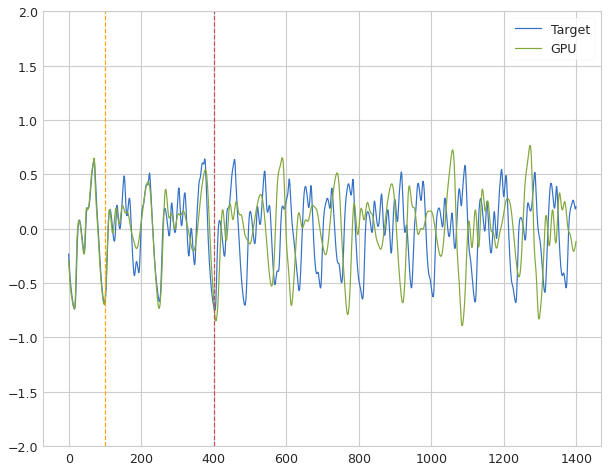

 Iter=50 a=0.527 sr=1.032 amp=1.000  ri=0.306 rr=1.873 loss=0.199477
Iter: 50 #### Time 6.29  NRMSE 0.091 CD 0.109
Iter: 51 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.67  NRMSE 0.316 CD 1.229
Iter: 55 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.63  NRMSE 0.296 CD 1.182
Iter: 57 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.62  NRMSE 0.228 CD 0.852
Iter: 59 #### Time 5.48  NRMSE 0.218 CD 0.989
Iter: 60 #### Time 5.53  NRMSE 0.232 CD 1.007
Iter: 61 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 65 #### Time 5.56  NRMSE 0.208 CD 0.881
Iter: 66 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.48  NRMSE 0.257 CD 0.398
Iter: 68 #### Time 5.73  NRMSE 0.250 CD 1.079
Iter: 69 #### Time 5.61  NRMSE 0.275 CD 0.959
I

Iter: 16 #### Time 5.54  NRMSE 0.237 CD 0.766
Iter: 17 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.58  NRMSE 0.238 CD 0.936
Iter: 19 #### Time 5.49  NRMSE 0.197 CD 0.722
Iter: 20 #### Time 5.53  NRMSE 0.251 CD 0.993
Iter: 21 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.52  NRMSE 0.165 CD 0.393
Iter: 24 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.51  NRMSE 0.391 CD 1.398
Iter: 27 #### Time 5.68  NRMSE 0.271 CD 0.891
Iter: 28 #### Time 5.50  NRMSE 0.281 CD 1.004
Iter: 29 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 30 #### Time 5.53  NRMSE 0.163 CD 0.419
Iter: 31 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.59  NRMSE 0.318 CD 1.076
Iter: 35 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.56  NRMSE 0.239 CD 0.786
Iter: 37 #### Time 5.52 

Iter: 88 #### Time 5.56  NRMSE 0.202 CD 0.799
Iter: 89 #### Time 5.57  NRMSE 87050490288154509312.000 CD 1.000
Iter: 90 #### Time 5.62  NRMSE 33.632 CD 0.887
Iter: 91 #### Time 6.06  NRMSE 0.217 CD 0.947
Iter: 92 #### Time 6.18  NRMSE 0.147 CD 0.315
Iter: 93 #### Time 5.91  NRMSE 0.213 CD 0.750
Iter: 94 #### Time 6.14  NRMSE 0.199 CD 0.778
Iter: 95 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 96 #### Time 6.11  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.93  NRMSE 0.216 CD 0.932
Iter: 98 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.95  NRMSE 3450.195 CD 0.859
End Run 3 Time 573.450

Best result = 0.4627189961061644
a = 0.4045532722329994
sr = 1.0128719811102374
amp = 0.38056557276663283
ri = 2.2317188338016116
********** Size20 ref 3 -- Run 4 ***********
Iter: 0 #### Time 6.04  NRMSE 0.328 CD 1.294
Iter: 1 #### Time 6.02  NRMSE 0.283 CD 1.105
Iter: 2 #### Time 6.20  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.75  NRMSE 0.408 CD 0.921
Iter: 4 #### Time 5.78  NRMSE 1000.000 CD 

Iter: 44 #### Time 7.10  NRMSE 1000.000 CD nan
Iter: 45 #### Time 7.15  NRMSE 0.181 CD 0.548
Iter: 46 #### Time 7.62  NRMSE 0.212 CD 0.931
Iter: 47 #### Time 7.63  NRMSE 1000.000 CD nan
Iter: 48 #### Time 6.87  NRMSE 1000.000 CD nan
Iter: 49 #### Time 7.83  NRMSE 0.162 CD 0.372
Iter: 50 #### Time 7.55  NRMSE 0.363 CD 1.489
Iter: 51 #### Time 6.92  NRMSE 6148746651341216752336896.000 CD 1.000
Iter: 52 #### Time 7.25  NRMSE 0.166 CD 0.420
Iter: 53 #### Time 7.05  NRMSE 1000.000 CD nan
Iter: 54 #### Time 7.20  NRMSE 0.222 CD 1.038
Iter: 55 #### Time 7.05  NRMSE 1000.000 CD nan
Iter: 56 #### Time 6.82  NRMSE 0.246 CD 0.942
Iter: 57 #### Time 7.61  NRMSE 0.232 CD 0.787
Iter: 58 #### Time 7.23  NRMSE 1000.000 CD nan
Iter: 59 #### Time 7.32  NRMSE 1000.000 CD nan
Iter: 60 #### Time 7.05  NRMSE 1000.000 CD nan
Iter: 61 #### Time 7.80  NRMSE 0.277 CD 1.045
Iter: 62 #### Time 7.28  NRMSE 1000.000 CD nan
Iter: 63 #### Time 7.21  NRMSE 1000.000 CD nan
Iter: 64 #### Time 7.25  NRMSE 0.235 CD 0.863


Iter: 12 #### Time 7.23  NRMSE 0.184 CD 0.617
Iter: 13 #### Time 7.36  NRMSE 0.177 CD 0.444
Iter: 14 #### Time 7.26  NRMSE 0.203 CD 0.831
Iter: 15 #### Time 6.99  NRMSE 1000.000 CD nan
Iter: 16 #### Time 7.75  NRMSE 0.206 CD 0.923
Iter: 17 #### Time 7.12  NRMSE 1000.000 CD nan
Iter: 18 #### Time 7.37  NRMSE 0.213 CD 0.946
Iter: 19 #### Time 7.02  NRMSE 1000.000 CD nan
Iter: 20 #### Time 7.43  NRMSE 0.170 CD 0.438
Iter: 21 #### Time 7.07  NRMSE 0.287 CD 1.035
Iter: 22 #### Time 6.94  NRMSE 93.880 CD 0.998
Iter: 23 #### Time 7.19  NRMSE 1000.000 CD nan
Iter: 24 #### Time 7.57  NRMSE 0.208 CD 0.840
Iter: 25 #### Time 7.39  NRMSE 0.146 CD 0.302
Iter: 26 #### Time 7.16  NRMSE 1000.000 CD nan
Iter: 27 #### Time 8.08  NRMSE 0.182 CD 0.593
Iter: 28 #### Time 8.91  NRMSE 0.233 CD 0.832
Iter: 29 #### Time 6.98  NRMSE 0.177 CD 0.288
Iter: 30 #### Time 7.78  NRMSE 0.178 CD 0.544
Iter: 31 #### Time 6.91  NRMSE 0.267 CD 1.038
Iter: 32 #### Time 6.80  NRMSE 1000.000 CD nan
Iter: 33 #### Time 6.79  NR

Iter: 84 #### Time 7.27  NRMSE 0.194 CD 0.745
Iter: 85 #### Time 6.77  NRMSE 1000.000 CD nan
Iter: 86 #### Time 6.90  NRMSE 0.248 CD 0.932
Iter: 87 #### Time 8.23  NRMSE 1000.000 CD nan
Iter: 88 #### Time 6.58  NRMSE 1000.000 CD nan
Iter: 89 #### Time 7.26  NRMSE 1000.000 CD nan
Iter: 90 #### Time 6.87  NRMSE 1000.000 CD nan
Iter: 91 #### Time 6.80  NRMSE 1000.000 CD nan
Iter: 92 #### Time 6.95  NRMSE 0.188 CD 0.677
Iter: 93 #### Time 6.88  NRMSE 1000.000 CD nan
Iter: 94 #### Time 7.11  NRMSE 1000.000 CD nan
Iter: 95 #### Time 7.12  NRMSE 0.247 CD 0.747
Iter: 96 #### Time 7.61  NRMSE 0.268 CD 0.987
Iter: 97 #### Time 7.20  NRMSE 0.195 CD 0.769
Iter: 98 #### Time 7.14  NRMSE 1000.000 CD nan
Iter: 99 #### Time 7.15  NRMSE 0.332 CD 1.225
End Run 3 Time 763.765

Best result = 0.4778019638460509
a = 0.4753683290461202
sr = 1.1391314745099308
amp = 0.33918810699295515
ri = 1.8314935815517277
********** Size20 ref 4 -- Run 4 ***********
Iter: 0 #### Time 6.97  NRMSE 1000.000 CD nan
Iter: 1 ##

Iter: 46 #### Time 6.89  NRMSE 1000.000 CD nan
Iter: 47 #### Time 7.03  NRMSE 0.192 CD 0.685
Iter: 48 #### Time 6.92  NRMSE 0.257 CD 1.071
Iter: 49 #### Time 7.03  NRMSE 1000.000 CD nan
Iter: 50 #### Time 7.01  NRMSE 1000.000 CD nan
Iter: 51 #### Time 6.73  NRMSE 0.235 CD 0.777
Iter: 52 #### Time 7.16  NRMSE 1000.000 CD nan
Iter: 53 #### Time 6.83  NRMSE 1000.000 CD nan
Iter: 54 #### Time 6.79  NRMSE 2.742 CD 1.054
Iter: 55 #### Time 6.75  NRMSE 0.208 CD 0.601
Iter: 56 #### Time 6.91  NRMSE 0.179 CD 0.561
Iter: 57 #### Time 8.27  NRMSE 0.209 CD 0.824
Iter: 58 #### Time 7.79  NRMSE 0.265 CD 1.254
Iter: 59 #### Time 7.10  NRMSE 0.276 CD 1.005
Iter: 60 #### Time 6.85  NRMSE 1000.000 CD nan
Iter: 61 #### Time 6.87  NRMSE 0.215 CD 0.819
Iter: 62 #### Time 7.14  NRMSE 0.300 CD 0.812
Iter: 63 #### Time 7.64  NRMSE 0.226 CD 0.932
Iter: 64 #### Time 8.43  NRMSE 0.190 CD 0.707
Iter: 65 #### Time 7.02  NRMSE 0.161 CD 0.402
Iter: 66 #### Time 7.27  NRMSE 0.214 CD 0.637
Iter: 67 #### Time 7.47  NRM

Iter: 15 #### Time 6.74  NRMSE 1000.000 CD nan
Iter: 16 #### Time 7.41  NRMSE 0.179 CD 0.561
Iter: 17 #### Time 6.79  NRMSE 0.189 CD 0.676
Iter: 18 #### Time 7.27  NRMSE 0.311 CD 1.071
Iter: 19 #### Time 7.75  NRMSE 0.221 CD 0.633
Iter: 20 #### Time 9.31  NRMSE 1000.000 CD nan
Iter: 21 #### Time 8.73  NRMSE 1000.000 CD nan
Iter: 22 #### Time 8.87  NRMSE 1000.000 CD nan
Iter: 23 #### Time 7.77  NRMSE 0.210 CD 0.580
Iter: 24 #### Time 7.96  NRMSE 1000.000 CD nan
Iter: 25 #### Time 7.33  NRMSE 1000.000 CD nan
Iter: 26 #### Time 8.00  NRMSE 1000.000 CD nan
Iter: 27 #### Time 8.01  NRMSE 0.215 CD 0.736
Iter: 28 #### Time 7.86  NRMSE 1000.000 CD nan
Iter: 29 #### Time 8.36  NRMSE 0.294 CD 1.216
Iter: 30 #### Time 7.53  NRMSE 0.202 CD 0.671
Iter: 31 #### Time 9.53  NRMSE 1000.000 CD nan
Iter: 32 #### Time 8.04  NRMSE 0.179 CD 0.496
Iter: 33 #### Time 7.10  NRMSE 1000.000 CD nan
Iter: 34 #### Time 8.76  NRMSE 1000.000 CD nan
Iter: 35 #### Time 7.19  NRMSE 1000.000 CD nan
Iter: 36 #### Time 8.0

Iter: 87 #### Time 7.81  NRMSE 17774406842521393386494206964400128.000 CD 1.000
Iter: 88 #### Time 9.87  NRMSE 0.200 CD 0.514
Iter: 89 #### Time 8.83  NRMSE 1000.000 CD nan
Iter: 90 #### Time 8.66  NRMSE 1000.000 CD nan
Iter: 91 #### Time 8.09  NRMSE 0.178 CD 0.406
Iter: 92 #### Time 8.23  NRMSE 1000.000 CD nan
Iter: 93 #### Time 8.77  NRMSE 0.260 CD 0.986
Iter: 94 #### Time 9.28  NRMSE 0.263 CD 0.919
Iter: 95 #### Time 7.50  NRMSE 0.169 CD 0.460
Iter: 96 #### Time 8.00  NRMSE 1000.000 CD nan
Iter: 97 #### Time 8.33  NRMSE 1000.000 CD nan
Iter: 98 #### Time 7.11  NRMSE 1000.000 CD nan
Iter: 99 #### Time 8.24  NRMSE 0.214 CD 0.872
End Run 3 Time 773.123

Best result = 0.44394885784294635
a = 0.5018039326963439
sr = 1.1574361801094648
amp = 0.34740511947598085
ri = 2.237443851479062
********** Size18 ref 0 -- Run 4 ***********
Iter: 0 #### Time 7.07  NRMSE 0.275 CD 0.783
Iter: 1 #### Time 7.56  NRMSE 0.199 CD 0.788
Iter: 2 #### Time 8.40  NRMSE 0.259 CD 0.908
Iter: 3 #### Time 7.49  NRMS

Iter: 52 #### Time 6.07  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.84  NRMSE 9.374 CD 0.880
Iter: 55 #### Time 5.73  NRMSE 13.063 CD 1.083
Iter: 56 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.63  NRMSE 0.205 CD 0.907
Iter: 59 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.53  NRMSE 0.423 CD 0.780
Iter: 61 #### Time 5.58  NRMSE 0.243 CD 0.930
Iter: 62 #### Time 5.70  NRMSE 0.465 CD 0.931
Iter: 63 #### Time 5.66  NRMSE 0.227 CD 0.670
Iter: 64 #### Time 5.87  NRMSE 0.196 CD 0.735
Iter: 65 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 66 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.81  NRMSE 0.202 CD 0.651
Iter: 68 #### Time 5.77  NRMSE 0.234 CD 0.992
Iter: 69 #### Time 6.01  NRMSE 0.213 CD 0.855
Iter: 70 #### Time 5.77  NRMSE 0.290 CD 1.153
Iter: 71 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.79 

Iter: 20 #### Time 6.03  NRMSE 0.217 CD 0.808
Iter: 21 #### Time 6.06  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.88  NRMSE 0.202 CD 0.490
Iter: 23 #### Time 5.87  NRMSE 0.325 CD 1.298
Iter: 24 #### Time 6.08  NRMSE 0.271 CD 0.955
Iter: 25 #### Time 6.22  NRMSE 0.211 CD 0.989
Iter: 26 #### Time 5.91  NRMSE 0.199 CD 0.796
Iter: 27 #### Time 5.88  NRMSE 0.247 CD 0.734
Iter: 28 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.78  NRMSE 0.274 CD 0.754
Iter: 30 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 31 #### Time 6.03  NRMSE 0.312 CD 1.030
Iter: 32 #### Time 5.95  NRMSE 0.202 CD 0.864
Iter: 33 #### Time 6.98  NRMSE 1000.000 CD nan
Iter: 34 #### Time 6.36  NRMSE 0.246 CD 0.870
Iter: 35 #### Time 5.98  NRMSE 0.187 CD 0.662
Iter: 36 #### Time 7.86  NRMSE 1.305 CD 1.053
Iter: 37 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.87  NRMSE 0.197 CD 0.498
Iter: 39 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 40 #### Time 6.18  NRMSE 0.163 CD 0.408
Iter: 41 #### Time 6.95  NRM

Iter: 92 #### Time 7.48  NRMSE 0.256 CD 1.190
Iter: 93 #### Time 5.95  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.98  NRMSE 0.193 CD 0.752
Iter: 95 #### Time 5.93  NRMSE 1000.000 CD nan
Iter: 96 #### Time 6.26  NRMSE 0.205 CD 0.851
Iter: 97 #### Time 6.12  NRMSE 1000.000 CD nan
Iter: 98 #### Time 5.89  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.95  NRMSE 1000.000 CD nan
End Run 3 Time 609.812

Best result = 0.538100462573066
a = 0.5301004200912656
sr = 1.060324895126485
amp = 0.3081524439074791
ri = 1.1809241621652855
********** Size18 ref 1 -- Run 4 ***********
Iter: 0 #### Time 6.02  NRMSE 0.231 CD 1.107
Iter: 1 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.82  NRMSE 0.266 CD 0.960
Iter: 3 #### Time 5.98  NRMSE 1000.000 CD nan
Iter: 4 #### Time 6.08  NRMSE 1000.000 CD nan
Iter: 5 #### Time 6.27  NRMSE 0.361 CD 1.290
Iter: 6 #### Time 5.95  NRMSE 3309142092414926707197214720.000 CD 1.000
Iter: 7 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 8 #### Time 5.95  NRMSE 1000.000 C

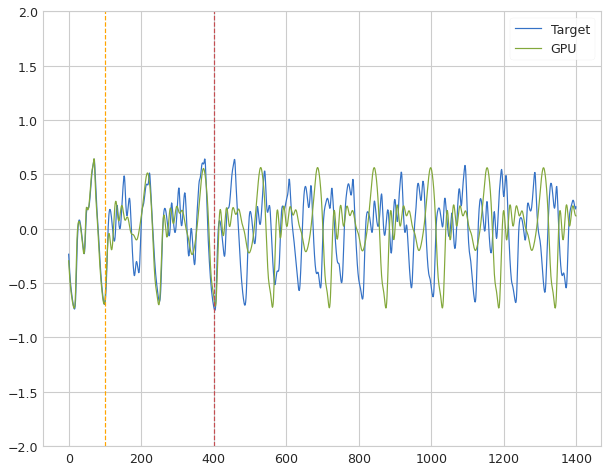

 Iter=31 a=0.431 sr=1.111 amp=1.000  ri=0.381 rr=2.477 loss=0.225260
Iter: 31 #### Time 6.94  NRMSE 0.097 CD 0.128
Iter: 32 #### Time 7.39  NRMSE 1000.000 CD nan
Iter: 33 #### Time 7.18  NRMSE 1000.000 CD nan
Iter: 34 #### Time 6.08  NRMSE 0.199 CD 0.798
Iter: 35 #### Time 6.15  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.71  NRMSE 0.205 CD 0.857
Iter: 37 #### Time 6.18  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.95  NRMSE 1000.000 CD nan
Iter: 39 #### Time 6.13  NRMSE 0.186 CD 0.641
Iter: 40 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.89  NRMSE 0.302 CD 1.164
Iter: 42 #### Time 5.93  NRMSE 0.227 CD 0.708
Iter: 43 #### Time 5.91  NRMSE 0.223 CD 1.015
Iter: 44 #### Time 5.94  NRMSE 1000.000 CD nan
Iter: 45 #### Time 6.31  NRMSE 0.217 CD 0.904
Iter: 46 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 47 #### Time 6.59  NRMSE 0.233 CD 0.805
Iter: 48 #### Time 6.80  NRMSE 1000.000 CD nan
Iter: 49 #### Time 6.93  NRMSE 1000.000 CD nan
Iter: 50 #### Time 6.43  NRMSE 0.180 CD 0.560
I

Iter: 0 #### Time 7.98  NRMSE 0.247 CD 1.013
Iter: 1 #### Time 6.75  NRMSE 0.165 CD 0.400
Iter: 2 #### Time 6.10  NRMSE 0.228 CD 0.685
Iter: 3 #### Time 5.97  NRMSE 1000.000 CD nan
Iter: 4 #### Time 7.08  NRMSE 43522119558404.750 CD 0.721
Iter: 5 #### Time 6.30  NRMSE 0.332 CD 1.169
Iter: 6 #### Time 6.17  NRMSE 0.193 CD 0.744
Iter: 7 #### Time 5.55  NRMSE 0.219 CD 0.815
Iter: 8 #### Time 5.64  NRMSE 0.194 CD 0.720
Iter: 9 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 10 #### Time 5.68  NRMSE 0.252 CD 0.878
Iter: 11 #### Time 5.81  NRMSE 0.251 CD 1.087
Iter: 12 #### Time 5.69  NRMSE 0.248 CD 1.153
Iter: 13 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 14 #### Time 5.76  NRMSE 0.218 CD 0.693
Iter: 15 #### Time 5.64  NRMSE 0.257 CD 0.841
Iter: 16 #### Time 5.56  NRMSE 0.243 CD 0.909
Iter: 17 #### Time 5.69  NRMSE 0.240 CD 0.712
Iter: 18 #### Time 5.61  NRMSE 0.201 CD 0.857
Iter: 19 #### Time 5.62  NRMSE 0.226 CD 0.721
Iter: 20 #### Time 5.70  NRMSE 1000.000 CD nan
Iter: 21 #### Time 5.70  NR

Iter: 73 #### Time 5.79  NRMSE 0.299 CD 1.086
Iter: 74 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.70  NRMSE 0.217 CD 0.727
Iter: 76 #### Time 5.82  NRMSE 0.340 CD 1.465
Iter: 77 #### Time 5.77  NRMSE 1000.000 CD nan
Iter: 78 #### Time 6.19  NRMSE 0.197 CD 0.796
Iter: 79 #### Time 5.84  NRMSE 0.191 CD 0.688
Iter: 80 #### Time 5.79  NRMSE 0.296 CD 1.033
Iter: 81 #### Time 5.72  NRMSE 0.178 CD 0.544
Iter: 82 #### Time 5.60  NRMSE 0.283 CD 1.173
Iter: 83 #### Time 5.68  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.67  NRMSE 0.262 CD 1.095
Iter: 86 #### Time 5.81  NRMSE 0.243 CD 1.011
Iter: 87 #### Time 5.79  NRMSE 0.216 CD 0.911
Iter: 88 #### Time 5.66  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.64  NRMSE 0.184 CD 0.610
Iter: 91 #### Time 5.66  NRMSE 0.204 CD 0.834
Iter: 92 #### Time 5.61  NRMSE 0.225 CD 0.993
Iter: 93 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 94 #### Time 7.29  NR

Iter: 29 #### Time 5.68  NRMSE 0.456 CD 1.130
Iter: 30 #### Time 5.75  NRMSE 0.243 CD 1.110
Iter: 31 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.75  NRMSE 0.203 CD 0.852
Iter: 34 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.77  NRMSE 0.206 CD 0.826
Iter: 37 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.78  NRMSE 0.241 CD 1.163
Iter: 39 #### Time 5.76  NRMSE 0.322 CD 1.147
Iter: 40 #### Time 6.15  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.82  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.81  NRMSE 0.181 CD 0.537
Iter: 43 #### Time 5.86  NRMSE 1000.000 CD nan
Iter: 44 #### Time 5.78  NRMSE 0.272 CD 1.169
Iter: 45 #### Time 6.06  NRMSE 0.197 CD 0.747
Iter: 46 #### Time 5.95  NRMSE 1000.000 CD nan
Iter: 47 #### Time 5.84  NRMSE 0.189 CD 0.683
Iter: 48 #### Time 6.16  NRMSE 0.345 CD 0.933
Iter: 49 #### Time 5.90  NRMSE 0.202 CD 0.651
Iter: 50 #### Time 5.85  

Iter: 0 #### Time 5.71  NRMSE 0.209 CD 0.765
Iter: 1 #### Time 5.96  NRMSE 0.191 CD 0.718
Iter: 2 #### Time 6.55  NRMSE 0.203 CD 0.891
Iter: 3 #### Time 6.46  NRMSE 1000.000 CD nan
Iter: 4 #### Time 6.01  NRMSE 1000.000 CD nan
Iter: 5 #### Time 5.85  NRMSE 0.317 CD 1.086
Iter: 6 #### Time 5.94  NRMSE 1000.000 CD nan
Iter: 7 #### Time 6.19  NRMSE 0.207 CD 0.955
Iter: 8 #### Time 6.06  NRMSE 0.238 CD 0.877
Iter: 9 #### Time 5.96  NRMSE 0.251 CD 0.635
Iter: 10 #### Time 5.91  NRMSE 1000.000 CD nan
Iter: 11 #### Time 7.12  NRMSE 0.191 CD 0.717
Iter: 12 #### Time 6.10  NRMSE 0.260 CD 1.171
Iter: 13 #### Time 6.53  NRMSE 1000.000 CD nan
Iter: 14 #### Time 6.43  NRMSE 0.212 CD 0.584
Iter: 15 #### Time 6.36  NRMSE 1000.000 CD nan
Iter: 16 #### Time 6.29  NRMSE 1000.000 CD nan
Iter: 17 #### Time 6.25  NRMSE 1000.000 CD nan
Iter: 18 #### Time 6.51  NRMSE 0.312 CD 1.117
Iter: 19 #### Time 6.07  NRMSE 1000.000 CD nan
Iter: 20 #### Time 6.11  NRMSE 0.179 CD 0.533
Iter: 21 #### Time 5.99  NRMSE 0.33

Iter: 73 #### Time 5.64  NRMSE 0.241 CD 0.866
Iter: 74 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.77  NRMSE 0.196 CD 0.468
Iter: 76 #### Time 5.73  NRMSE 0.192 CD 0.708
Iter: 77 #### Time 5.74  NRMSE 0.281 CD 0.951
Iter: 78 #### Time 5.81  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.78  NRMSE 0.169 CD 0.462
Iter: 80 #### Time 5.69  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.59  NRMSE 0.357 CD 1.082
Iter: 83 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.76  NRMSE 0.326 CD 1.266
Iter: 85 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.78  NRMSE 0.265 CD 1.206
Iter: 87 #### Time 5.77  NRMSE 0.256 CD 0.791
Iter: 88 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.63  NRMSE 0.265 CD 1.013
Iter: 90 #### Time 5.83  NRMSE 0.196 CD 0.757
Iter: 91 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.71  NRMSE 0.232 CD 1.099
Iter: 93 #### Time 5.69  NRMSE 0.283 CD 0.982
Iter: 94 #### Time 5.70  N

Iter: 37 #### Time 7.57  NRMSE 0.318 CD 1.027
Iter: 38 #### Time 6.70  NRMSE 0.215 CD 0.795
Iter: 39 #### Time 7.28  NRMSE 1000.000 CD nan
Iter: 40 #### Time 6.92  NRMSE 0.320 CD 1.180
Iter: 41 #### Time 5.65  NRMSE 0.301 CD 1.120
Iter: 42 #### Time 5.77  NRMSE 0.215 CD 0.901
Iter: 43 #### Time 5.70  NRMSE 0.228 CD 1.086
Iter: 44 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 45 #### Time 5.62  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 47 #### Time 5.95  NRMSE 1000.000 CD nan
Iter: 48 #### Time 6.03  NRMSE 1000.000 CD nan
Iter: 49 #### Time 6.12  NRMSE 0.187 CD 0.405
Iter: 50 #### Time 6.12  NRMSE 0.197 CD 0.735
Iter: 51 #### Time 6.08  NRMSE 1000.000 CD nan
Iter: 52 #### Time 6.05  NRMSE 0.219 CD 0.903
Iter: 53 #### Time 5.99  NRMSE 0.199 CD 0.778
Iter: 54 #### Time 5.53  NRMSE 0.301 CD 1.350
Iter: 55 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.79  NRMSE 0.207 CD 0.855
Iter: 57 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.73  

Iter: 4 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 5 #### Time 7.52  NRMSE 1000.000 CD nan
Iter: 6 #### Time 7.99  NRMSE 1000.000 CD nan
Iter: 7 #### Time 6.60  NRMSE 0.184 CD 0.559
Iter: 8 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 9 #### Time 5.86  NRMSE 0.217 CD 0.574
Iter: 10 #### Time 8.69  NRMSE 2.796 CD 0.904
Iter: 11 #### Time 7.02  NRMSE 76960407667294277919047680.000 CD 1.000
Iter: 12 #### Time 5.92  NRMSE 0.157 CD 0.374
Iter: 13 #### Time 6.14  NRMSE 0.317 CD 1.224
Iter: 14 #### Time 6.50  NRMSE 0.191 CD 0.689
Iter: 15 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 16 #### Time 6.21  NRMSE 0.262 CD 1.054
Iter: 17 #### Time 6.13  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.88  NRMSE 0.201 CD 0.796
Iter: 20 #### Time 6.25  NRMSE 1000.000 CD nan
Iter: 21 #### Time 6.02  NRMSE 1000.000 CD nan
Iter: 22 #### Time 6.16  NRMSE 1000.000 CD nan
Iter: 23 #### Time 6.00  NRMSE 0.198 CD 0.567
Iter: 24 #### Time 6.56  NRMSE 1000.000 CD nan
Iter

Iter: 76 #### Time 6.54  NRMSE 1000.000 CD nan
Iter: 77 #### Time 6.04  NRMSE 25.030 CD 0.895
Iter: 78 #### Time 6.32  NRMSE 0.204 CD 0.833
Iter: 79 #### Time 6.04  NRMSE 1000.000 CD nan
Iter: 80 #### Time 6.04  NRMSE 0.227 CD 0.699
Iter: 81 #### Time 5.98  NRMSE 0.203 CD 0.870
Iter: 82 #### Time 5.91  NRMSE 0.195 CD 0.790
Iter: 83 #### Time 7.53  NRMSE 0.181 CD 0.577
Iter: 84 #### Time 6.42  NRMSE 0.191 CD 0.711
Iter: 85 #### Time 6.00  NRMSE 1000.000 CD nan
Iter: 86 #### Time 6.00  NRMSE 1000.000 CD nan
Iter: 87 #### Time 5.90  NRMSE 0.726 CD 1.248
Iter: 88 #### Time 6.68  NRMSE 0.200 CD 0.806
Iter: 89 #### Time 7.92  NRMSE 0.257 CD 1.047
Iter: 90 #### Time 7.10  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.96  NRMSE 0.295 CD 1.111
Iter: 92 #### Time 5.94  NRMSE 0.228 CD 0.949
Iter: 93 #### Time 6.02  NRMSE 1000.000 CD nan
Iter: 94 #### Time 6.46  NRMSE 1000.000 CD nan
Iter: 95 #### Time 5.93  NRMSE 8.119 CD 1.001
Iter: 96 #### Time 5.95  NRMSE 0.195 CD 0.541
Iter: 97 #### Time 6.20  N

Iter: 38 #### Time 5.52  NRMSE 0.205 CD 0.883
Iter: 39 #### Time 5.77  NRMSE 0.291 CD 0.981
Iter: 40 #### Time 5.57  NRMSE 0.320 CD 1.161
Iter: 41 #### Time 5.68  NRMSE 0.273 CD 1.069
Iter: 42 #### Time 5.43  NRMSE 0.227 CD 0.867
Iter: 43 #### Time 5.51  NRMSE 0.209 CD 0.625
Iter: 44 #### Time 5.43  NRMSE 0.225 CD 0.859
Iter: 45 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.58  NRMSE 0.208 CD 0.825
Iter: 47 #### Time 5.70  NRMSE 1000.000 CD nan
Iter: 48 #### Time 5.83  NRMSE 0.293 CD 1.068
Iter: 49 #### Time 5.83  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.72  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.43  NRMSE 0.194 CD 0.406
Iter: 55 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.49  NRMSE 0.222 CD 0.995
Iter: 57 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 59 #### Time 5.50 

Iter: 6 #### Time 5.60  NRMSE 0.181 CD 0.383
Iter: 7 #### Time 5.44  NRMSE 0.225 CD 0.649
Iter: 8 #### Time 5.52  NRMSE 0.224 CD 0.907
Iter: 9 #### Time 5.53  NRMSE 0.262 CD 1.052
Iter: 10 #### Time 5.48  NRMSE 0.228 CD 0.962
Iter: 11 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 12 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 14 #### Time 5.74  NRMSE 0.162 CD 0.334
Iter: 15 #### Time 5.52  NRMSE 0.230 CD 0.962
Iter: 16 #### Time 5.41  NRMSE 0.185 CD 0.588
Iter: 17 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.45  NRMSE 0.179 CD 0.549
Iter: 20 #### Time 5.43  NRMSE 0.360 CD 1.388
Iter: 21 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.38  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.41  NRMSE 0.199 CD 0.813
Iter: 27 #### Time 5.50  NRM

Iter: 78 #### Time 5.56  NRMSE 0.207 CD 0.918
Iter: 79 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.79  NRMSE 0.294 CD 1.191
Iter: 82 #### Time 5.55  NRMSE 0.191 CD 0.717
Iter: 83 #### Time 5.48  NRMSE 0.291 CD 1.157
Iter: 84 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 87 #### Time 5.48  NRMSE 0.276 CD 0.769
Iter: 88 #### Time 5.45  NRMSE 0.202 CD 0.808
Iter: 89 #### Time 5.43  NRMSE 0.223 CD 0.682
Iter: 90 #### Time 5.45  NRMSE 0.296 CD 1.368
Iter: 91 #### Time 5.41  NRMSE 0.183 CD 0.597
Iter: 92 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 93 #### Time 5.48  NRMSE 0.229 CD 0.798
Iter: 94 #### Time 5.52  NRMSE 0.184 CD 0.420
Iter: 95 #### Time 5.46  NRMSE 0.207 CD 0.856
Iter: 96 #### Time 5.44  NRMSE 0.329 CD 1.311
Iter: 97 #### Time 5.44  NRMSE 0.306 CD 1.219
Iter: 98 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.50  NR

Iter: 43 #### Time 5.44  NRMSE 0.312 CD 1.019
Iter: 44 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 45 #### Time 5.47  NRMSE 0.267 CD 0.726
Iter: 46 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 47 #### Time 5.47  NRMSE 0.184 CD 0.437
Iter: 48 #### Time 5.47  NRMSE 0.247 CD 0.695
Iter: 49 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.53  NRMSE 0.256 CD 1.064
Iter: 52 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.46  NRMSE 0.256 CD 1.001
Iter: 55 #### Time 5.54  NRMSE 0.367 CD 1.068
Iter: 56 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.45  NRMSE 0.231 CD 0.799
Iter: 58 #### Time 5.47  NRMSE 0.206 CD 0.873
Iter: 59 #### Time 5.43  NRMSE 0.182 CD 0.588
Iter: 60 #### Time 5.46  NRMSE 0.224 CD 0.809
Iter: 61 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.48  NRMSE 0.252 CD 1.070
Iter: 63 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.49  

Iter: 10 #### Time 7.52  NRMSE 1000.000 CD nan
Iter: 11 #### Time 7.53  NRMSE 1000.000 CD nan
Iter: 12 #### Time 7.53  NRMSE 0.197 CD 0.800
Iter: 13 #### Time 7.66  NRMSE 1000.000 CD nan
Iter: 14 #### Time 7.73  NRMSE 0.300 CD 1.433
Iter: 15 #### Time 7.53  NRMSE 0.276 CD 1.039
Iter: 16 #### Time 7.59  NRMSE 0.196 CD 0.769
Iter: 17 #### Time 7.55  NRMSE 1000.000 CD nan
Iter: 18 #### Time 7.53  NRMSE 1000.000 CD nan
Iter: 19 #### Time 7.54  NRMSE 0.183 CD 0.585
Iter: 20 #### Time 7.48  NRMSE 1000.000 CD nan
Iter: 21 #### Time 7.55  NRMSE 0.170 CD 0.436
Iter: 22 #### Time 7.64  NRMSE 0.277 CD 0.969
Iter: 23 #### Time 7.55  NRMSE 0.230 CD 0.750
Iter: 24 #### Time 7.57  NRMSE 0.319 CD 1.111
Iter: 25 #### Time 7.52  NRMSE 0.190 CD 0.677
Iter: 26 #### Time 7.44  NRMSE 1000.000 CD nan
Iter: 27 #### Time 7.50  NRMSE 143363.316 CD 0.861
Iter: 28 #### Time 7.49  NRMSE 0.304 CD 1.276
Iter: 29 #### Time 7.61  NRMSE 1000.000 CD nan
Iter: 30 #### Time 7.56  NRMSE 1000.000 CD nan
Iter: 31 #### Time 7

Iter: 82 #### Time 5.49  NRMSE 0.193 CD 0.740
Iter: 83 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.46  NRMSE 0.182 CD 0.596
Iter: 86 #### Time 5.45  NRMSE 0.278 CD 1.127
Iter: 87 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 88 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.92  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.47  NRMSE 0.193 CD 0.743
Iter: 92 #### Time 5.50  NRMSE 0.235 CD 0.929
Iter: 93 #### Time 5.43  NRMSE 0.193 CD 0.630
Iter: 94 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 95 #### Time 5.47  NRMSE 0.214 CD 0.936
Iter: 96 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 98 #### Time 5.59  NRMSE 0.289 CD 1.041
Iter: 99 #### Time 5.66  NRMSE 1000.000 CD nan
End Run 3 Time 553.521

Best result = 0.318877415421787
a = 0.5686064178536483
sr = 1.021377411738949
amp = 0.39036994652168877
ri = 1.661596270564747
********** 

Iter: 47 #### Time 6.85  NRMSE 0.103 CD 0.122
Iter: 48 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 49 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.46  NRMSE 0.292 CD 0.988
Iter: 52 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.45  NRMSE 0.192 CD 0.718
Iter: 55 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.46  NRMSE 0.197 CD 0.665
Iter: 58 #### Time 5.49  NRMSE 0.303 CD 1.123
Iter: 59 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.59  NRMSE 0.324 CD 0.543
Iter: 61 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.59  NRMSE 0.185 CD 0.634
Iter: 65 #### Time 5.45  NRMSE 0.343 CD 1.131
Iter: 66 #### Time 5.46  NRMSE 0.201 CD 0.886
Iter: 67 #### Time 5.59  NRMSE 0.275 CD 1.057
Iter: 68 #### Time 5.48

Iter: 15 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 16 #### Time 5.60  NRMSE 0.247 CD 0.889
Iter: 17 #### Time 5.72  NRMSE 0.218 CD 0.841
Iter: 18 #### Time 7.45  NRMSE 1000.000 CD nan
Iter: 19 #### Time 7.51  NRMSE 0.183 CD 0.391
Iter: 20 #### Time 7.47  NRMSE 0.260 CD 0.970
Iter: 21 #### Time 7.44  NRMSE 0.373 CD 1.465
Iter: 22 #### Time 7.52  NRMSE 893177787185398656.000 CD 1.000
Iter: 23 #### Time 7.59  NRMSE 1000.000 CD nan
Iter: 24 #### Time 7.49  NRMSE 0.228 CD 0.988
Iter: 25 #### Time 7.51  NRMSE 0.267 CD 1.065
Iter: 26 #### Time 7.47  NRMSE 1000.000 CD nan
Iter: 27 #### Time 6.74  NRMSE 1000.000 CD nan
Iter: 28 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.48  NRMSE 0.214 CD 0.962
Iter: 30 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 31 #### Time 5.56  NRMSE 0.298 CD 1.124
Iter: 32 #### Time 5.50  NRMSE 0.235 CD 0.534
Iter: 33 #### Time 5.68  NRMSE 0.237 CD 0.952
Iter: 34 #### Time 5.54  NRMSE 0.320 CD 1.056
Iter: 35 #### Time 5.58  NRMSE 0.289 CD 1.196
Iter: 36 #

Iter: 88 #### Time 5.46  NRMSE 0.338 CD 1.052
Iter: 89 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.62  NRMSE 8.420 CD 0.894
Iter: 91 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 93 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.47  NRMSE 0.289 CD 1.125
Iter: 95 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.47  NRMSE 0.266 CD 1.097
Iter: 98 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.47  NRMSE 1000.000 CD nan
End Run 3 Time 578.256

Best result = 0.26396453228576006
a = 0.4362907667253103
sr = 1.1472196249691677
amp = 0.37719159055890433
ri = 2.389533078984859
********** Size16 ref 2 -- Run 4 ***********
Iter: 0 #### Time 5.87  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.64  NRMSE 0.238 CD 0.793
Iter: 2 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.53  NRMSE 0.217 CD 0.960
Iter: 4 #### Time 5.48  NRMSE 0.260 CD 0.990
Iter: 5 #### T

Iter: 54 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.49  NRMSE 36.937 CD 0.994
Iter: 56 #### Time 5.43  NRMSE 0.193 CD 0.740
Iter: 57 #### Time 5.48  NRMSE 0.326 CD 1.305
Iter: 58 #### Time 5.46  NRMSE 0.190 CD 0.692
Iter: 59 #### Time 5.54  NRMSE 0.251 CD 0.902
Iter: 60 #### Time 5.43  NRMSE 0.189 CD 0.505
Iter: 61 #### Time 5.48  NRMSE 0.264 CD 0.927
Iter: 62 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.51  NRMSE 0.284 CD 1.070
Iter: 65 #### Time 5.50  NRMSE 0.191 CD 0.692
Iter: 66 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.45  NRMSE 0.161 CD 0.403
Iter: 68 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.49  NRMSE 0.205 CD 0.699
Iter: 70 #### Time 5.78  NRMSE 0.207 CD 0.931
Iter: 71 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.49  NRMSE 0.229 CD 0.836
Iter: 73 #### Time 5.63  NRMSE 0.348 CD 1.350
Iter: 74 #### Time 5.46  NRMSE 0.182 CD 0.590
Iter: 75 #### Time 5.47  NR

Iter: 23 #### Time 5.62  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.51  NRMSE 0.269 CD 1.300
Iter: 27 #### Time 5.50  NRMSE 0.189 CD 0.685
Iter: 28 #### Time 5.48  NRMSE 0.216 CD 0.689
Iter: 29 #### Time 5.67  NRMSE 0.223 CD 1.036
Iter: 30 #### Time 5.66  NRMSE 0.211 CD 0.720
Iter: 31 #### Time 5.64  NRMSE 0.325 CD 1.251
Iter: 32 #### Time 5.65  NRMSE 0.182 CD 0.590
Iter: 33 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.49  NRMSE 0.269 CD 0.986
Iter: 35 #### Time 5.46  NRMSE 0.237 CD 1.107
Iter: 36 #### Time 5.46  NRMSE 0.264 CD 1.068
Iter: 37 #### Time 5.56  NRMSE 0.323 CD 1.239
Iter: 38 #### Time 5.64  NRMSE 0.205 CD 0.894
Iter: 39 #### Time 7.57  NRMSE 1000.000 CD nan
Iter: 40 #### Time 7.57  NRMSE 0.274 CD 0.583
Iter: 41 #### Time 7.84  NRMSE 1000.000 CD nan
Iter: 42 #### Time 7.53  NRMSE 0.195 CD 0.759
Iter: 43 #### Time 7.64  NRMSE 0.229 CD 0.539
Iter: 44 #### Time 7.52  NRM

Iter: 96 #### Time 5.50  NRMSE 0.192 CD 0.716
Iter: 97 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 98 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.45  NRMSE 1000.000 CD nan
End Run 3 Time 557.416

Best result = 0.2892649290194148
a = 0.5185484330690896
sr = 1.1983508760576067
amp = 0.3686242955321659
ri = 1.4237065180205648
********** Size16 ref 3 -- Run 4 ***********
Iter: 0 #### Time 5.53  NRMSE 0.276 CD 0.693
Iter: 1 #### Time 5.41  NRMSE 0.194 CD 0.698
Iter: 2 #### Time 5.41  NRMSE 0.290 CD 0.708
Iter: 3 #### Time 5.52  NRMSE 0.296 CD 0.956
Iter: 4 #### Time 5.47  NRMSE 0.163 CD 0.413
Iter: 5 #### Time 5.55  NRMSE 0.275 CD 1.240
Iter: 6 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 7 #### Time 5.46  NRMSE 0.206 CD 0.901
Iter: 8 #### Time 5.58  NRMSE 0.236 CD 1.012
Iter: 9 #### Time 5.61  NRMSE 0.177 CD 0.540
Iter: 10 #### Time 5.61  NRMSE 0.181 CD 0.587
Iter: 11 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 12 #### Time 5.55  NRMSE 0.215 CD 0.654
Iter: 13 #### Time 5.65  

Iter: 60 #### Time 5.57  NRMSE 0.206 CD 0.925
Iter: 61 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.48  NRMSE 0.303 CD 1.039
Iter: 63 #### Time 5.50  NRMSE 0.220 CD 0.929
Iter: 64 #### Time 5.68  NRMSE 0.213 CD 0.938
Iter: 65 #### Time 5.46  NRMSE 0.158 CD 0.373
Iter: 66 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.59  NRMSE 0.196 CD 0.818
Iter: 68 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.48  NRMSE 0.186 CD 0.580
Iter: 70 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 74 #### Time 5.48  NRMSE 0.447 CD 1.526
Iter: 75 #### Time 5.42  NRMSE 0.248 CD 1.072
Iter: 76 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 77 #### Time 5.41  NRMSE 0.268 CD 1.003
Iter: 78 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.42

Iter: 28 #### Time 5.45  NRMSE 0.229 CD 0.642
Iter: 29 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 30 #### Time 6.15  NRMSE 0.187 CD 0.652
Iter: 31 #### Time 7.25  NRMSE 0.189 CD 0.560
Iter: 32 #### Time 5.59  NRMSE 0.276 CD 0.973
Iter: 33 #### Time 5.43  NRMSE 0.207 CD 0.735
Iter: 34 #### Time 5.45  NRMSE 0.281 CD 1.017
Iter: 35 #### Time 5.51  NRMSE 0.243 CD 1.118
Iter: 36 #### Time 5.49  NRMSE 0.238 CD 1.112
Iter: 37 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.42  NRMSE 0.323 CD 1.315
Iter: 39 #### Time 5.42  NRMSE 13.978 CD 1.107
Iter: 40 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 41 #### Time 5.47  NRMSE 0.165 CD 0.381
Iter: 42 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 43 #### Time 5.42  NRMSE 0.190 CD 0.690
Iter: 44 #### Time 5.40  NRMSE 0.228 CD 1.085
Iter: 45 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.45  NRMSE 0.197 CD 0.800
Iter: 47 #### Time 5.39  NRMSE 0.384 CD 1.442
Iter: 48 #### Time 5.41  NRMSE 0.225 CD 0.716
Iter: 49 #### Time 5.49  NRM

Iter: 0 #### Time 5.42  NRMSE 0.237 CD 1.129
Iter: 1 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 4 #### Time 5.42  NRMSE 0.222 CD 0.892
Iter: 5 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 6 #### Time 5.46  NRMSE 0.381 CD 1.235
Iter: 7 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 8 #### Time 7.57  NRMSE 0.217 CD 0.740
Iter: 9 #### Time 7.26  NRMSE 1000.000 CD nan
Iter: 10 #### Time 6.12  NRMSE 0.218 CD 0.958
Iter: 11 #### Time 7.48  NRMSE 0.199 CD 0.782
Iter: 12 #### Time 7.47  NRMSE 0.253 CD 0.881
Iter: 13 #### Time 7.44  NRMSE 0.189 CD 0.606
Iter: 14 #### Time 7.48  NRMSE 1000.000 CD nan
Iter: 15 #### Time 6.48  NRMSE 230.356 CD 0.916
Iter: 16 #### Time 5.47  NRMSE 0.214 CD 0.763
Iter: 17 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.39  NRMSE 0.295 CD 1.184
Iter: 19 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.58  NRMSE 0.189 CD 0.603
Iter: 21 #### Time 5.42  NRMSE 0.

Iter: 68 #### Time 5.50  NRMSE 0.200 CD 0.819
Iter: 69 #### Time 5.64  NRMSE 0.230 CD 0.834
Iter: 70 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 74 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 75 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 76 #### Time 5.51  NRMSE 0.236 CD 1.050
Iter: 77 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 78 #### Time 5.53  NRMSE 0.304 CD 1.001
Iter: 79 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.49  NRMSE 0.241 CD 0.859
Iter: 81 #### Time 5.52  NRMSE 0.191 CD 0.710
Iter: 82 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 83 #### Time 5.52  NRMSE 0.211 CD 0.722
Iter: 84 #### Time 5.43  NRMSE 0.207 CD 0.861
Iter: 85 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.57  NRMSE 0.206 CD 0.771
Iter: 87 #### Time 5.45  NRMSE 0.237 CD 1.128
Iter: 88 #### Time 5.52  NRMSE 0.245 CD 1.006
Iter: 89 #### Time 5.82 

Iter: 37 #### Time 5.49  NRMSE 0.208 CD 0.817
Iter: 38 #### Time 5.53  NRMSE 0.237 CD 0.653
Iter: 39 #### Time 5.49  NRMSE 0.589 CD 1.059
Iter: 40 #### Time 5.57  NRMSE 0.244 CD 0.824
Iter: 41 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.51  NRMSE 0.202 CD 0.853
Iter: 43 #### Time 5.52  NRMSE 0.201 CD 0.791
Iter: 44 #### Time 5.54  NRMSE 0.252 CD 0.948
Iter: 45 #### Time 5.50  NRMSE 0.339 CD 1.287
Iter: 46 #### Time 5.45  NRMSE 0.240 CD 1.001
Iter: 47 #### Time 5.47  NRMSE 0.331 CD 1.205
Iter: 48 #### Time 5.48  NRMSE 0.256 CD 1.206
Iter: 49 #### Time 5.52  NRMSE 1.872 CD 1.241
Iter: 50 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.56  NRMSE 4342984716349864740882919456768.000 CD 1.000
Iter: 53 #### Time 5.50  NRMSE 0.191 CD 0.699
Iter: 54 #### Time 5.41  NRMSE 0.344 CD 1.338
Iter: 55 #### Time 5.54  NRMSE 0.165 CD 0.428
Iter: 56 #### Time 5.50  NRMSE 0.264 CD 1.050
Iter: 57 #### Time 5.64  NRMSE 0.221 CD 0.775
I

Iter: 5 #### Time 5.45  NRMSE 0.201 CD 0.804
Iter: 6 #### Time 5.51  NRMSE 0.302 CD 1.311
Iter: 7 #### Time 5.80  NRMSE 0.267 CD 0.900
Iter: 8 #### Time 5.59  NRMSE 0.280 CD 1.059
Iter: 9 #### Time 5.70  NRMSE 0.307 CD 1.243
Iter: 10 #### Time 5.55  NRMSE 20071.244 CD 1.137
Iter: 11 #### Time 6.21  NRMSE 0.228 CD 0.818
Iter: 12 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 14 #### Time 5.43  NRMSE 0.276 CD 1.105
Iter: 15 #### Time 5.41  NRMSE 0.251 CD 0.782
Iter: 16 #### Time 5.49  NRMSE 0.216 CD 0.855
Iter: 17 #### Time 5.50  NRMSE 0.110 CD 0.166
Iter: 18 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 19 #### Time 5.40  NRMSE 0.248 CD 1.101
Iter: 20 #### Time 5.53  NRMSE 0.168 CD 0.338
Iter: 21 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.51  NRMSE 0.195 CD 0.752
Iter: 23 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.45  NRMSE 0.255 CD 1.225
Iter: 26 #### Time 5.86  NRMS

Iter: 75 #### Time 5.48  NRMSE 0.275 CD 0.956
Iter: 76 #### Time 5.47  NRMSE 0.270 CD 0.770
Iter: 77 #### Time 5.52  NRMSE 0.207 CD 0.893
Iter: 78 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.46  NRMSE 0.193 CD 0.739
Iter: 80 #### Time 5.59  NRMSE 0.190 CD 0.698
Iter: 81 #### Time 5.43  NRMSE 0.240 CD 0.659
Iter: 82 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 83 #### Time 5.53  NRMSE 0.224 CD 0.820
Iter: 84 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.53  NRMSE 0.220 CD 0.916
Iter: 86 #### Time 5.47  NRMSE 0.207 CD 0.802
Iter: 87 #### Time 5.41  NRMSE 0.306 CD 1.125
Iter: 88 #### Time 5.38  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.40  NRMSE 0.269 CD 0.905
Iter: 93 #### Time 5.42  NRMSE 0.190 CD 0.698
Iter: 94 #### Time 5.41  NRMSE 0.258 CD 0.890
Iter: 95 #### Time 5.41  NRMSE 1000.000 CD nan
Iter: 96 #### Time 5.54  N

Iter: 44 #### Time 5.38  NRMSE 1000.000 CD nan
Iter: 45 #### Time 5.37  NRMSE 0.278 CD 1.080
Iter: 46 #### Time 5.50  NRMSE 0.191 CD 0.710
Iter: 47 #### Time 5.39  NRMSE 1000.000 CD nan
Iter: 48 #### Time 5.50  NRMSE 0.302 CD 1.089
Iter: 49 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 52 #### Time 5.34  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.46  NRMSE 0.302 CD 0.945
Iter: 56 #### Time 5.46  NRMSE 0.277 CD 0.995
Iter: 57 #### Time 5.42  NRMSE 2.284 CD 1.152
Iter: 58 #### Time 5.40  NRMSE 0.223 CD 0.935
Iter: 59 #### Time 5.46  NRMSE 0.228 CD 0.994
Iter: 60 #### Time 5.40  NRMSE 0.202 CD 0.804
Iter: 61 #### Time 5.37  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.41  NRMSE 0.181 CD 0.564
Iter: 63 #### Time 5.42  NRMSE 0.238 CD 0.849
Iter: 64 #### Time 5.34  NRMSE 0.278 CD 1.100
Iter: 65 #### Time 5.43  

Iter: 12 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.47  NRMSE 0.318 CD 1.067
Iter: 14 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 15 #### Time 5.47  NRMSE 0.323 CD 1.252
Iter: 16 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 17 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.45  NRMSE 0.272 CD 1.103
Iter: 19 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 21 #### Time 5.45  NRMSE 0.280 CD 0.830
Iter: 22 #### Time 5.62  NRMSE 0.318 CD 1.441
Iter: 23 #### Time 5.39  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.54  NRMSE 0.285 CD 1.100
Iter: 26 #### Time 5.40  NRMSE 0.280 CD 1.108
Iter: 27 #### Time 5.45  NRMSE 0.269 CD 1.170
Iter: 28 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 30 #### Time 5.45  NRMSE 0.354 CD 1.218
Iter: 31 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.5

Iter: 81 #### Time 5.55  NRMSE 0.235 CD 1.016
Iter: 82 #### Time 5.58  NRMSE 0.254 CD 0.965
Iter: 83 #### Time 5.66  NRMSE 0.223 CD 0.779
Iter: 84 #### Time 5.56  NRMSE 0.188 CD 0.467
Iter: 85 #### Time 5.52  NRMSE 0.259 CD 0.779
Iter: 86 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 87 #### Time 5.66  NRMSE 0.323 CD 1.127
Iter: 88 #### Time 5.50  NRMSE 0.208 CD 0.739
Iter: 89 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 90 #### Time 5.72  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.56  NRMSE 0.272 CD 0.765
Iter: 93 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.48  NRMSE 0.287 CD 0.945
Iter: 95 #### Time 5.50  NRMSE 0.207 CD 0.895
Iter: 96 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.49  NRMSE 0.203 CD 0.821
Iter: 98 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 99 #### Time 5.60  NRMSE 0.155 CD 0.373
End Run 0 Time 558.414

Best result = 0.5277840763005488
a = 0.5337315333974656
sr = 1.043433546569311
amp = 0.31951110

Iter: 50 #### Time 5.49  NRMSE 0.197 CD 0.766
Iter: 51 #### Time 5.51  NRMSE 0.289 CD 0.910
Iter: 52 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.56  NRMSE 0.201 CD 0.717
Iter: 54 #### Time 5.69  NRMSE 0.187 CD 0.663
Iter: 55 #### Time 5.49  NRMSE 0.279 CD 1.178
Iter: 56 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 57 #### Time 5.54  NRMSE 0.232 CD 0.679
Iter: 58 #### Time 5.47  NRMSE 0.239 CD 0.735
Iter: 59 #### Time 5.61  NRMSE 0.314 CD 1.130
Iter: 60 #### Time 5.45  NRMSE 0.184 CD 0.603
Iter: 61 #### Time 5.44  NRMSE 0.181 CD 0.585
Iter: 62 #### Time 5.49  NRMSE 0.409 CD 1.179
Iter: 63 #### Time 5.47  NRMSE 1000.000 CD nan
Iter: 64 #### Time 5.49  NRMSE 0.218 CD 0.561
Iter: 65 #### Time 5.61  NRMSE 0.285 CD 1.073
Iter: 66 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.48  NRMSE 0.184 CD 0.619
Iter: 68 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.49  NRMSE 0.299 CD 1.336
Iter: 70 #### Time 5.47  NRMSE 0.191 CD 0.489
Iter: 71 #### Time 5.41  NRMS

Iter: 19 #### Time 5.40  NRMSE 0.288 CD 1.172
Iter: 20 #### Time 5.40  NRMSE 0.196 CD 0.749
Iter: 21 #### Time 5.38  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 23 #### Time 5.61  NRMSE 0.213 CD 0.927
Iter: 24 #### Time 5.51  NRMSE 0.194 CD 0.715
Iter: 25 #### Time 5.44  NRMSE 0.292 CD 1.083
Iter: 26 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 27 #### Time 5.59  NRMSE 0.244 CD 0.757
Iter: 28 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.46  NRMSE 0.316 CD 1.259
Iter: 30 #### Time 5.58  NRMSE 0.315 CD 1.115
Iter: 31 #### Time 5.44  NRMSE 0.255 CD 0.851
Iter: 32 #### Time 5.53  NRMSE 0.196 CD 0.788
Iter: 33 #### Time 5.44  NRMSE 0.173 CD 0.476
Iter: 34 #### Time 5.38  NRMSE 0.325 CD 1.198
Iter: 35 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.63  NRMSE 0.252 CD 1.018
Iter: 37 #### Time 5.47  NRMSE 0.228 CD 0.809
Iter: 38 #### Time 5.44  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.42  NRMSE 0.219 CD 0.995
Iter: 40 #### Time 5.47  NRM

Iter: 89 #### Time 5.52  NRMSE 0.212 CD 0.590
Iter: 90 #### Time 5.84  NRMSE 0.315 CD 1.093
Iter: 91 #### Time 5.50  NRMSE 0.229 CD 0.954
Iter: 92 #### Time 5.44  NRMSE 0.359 CD 1.357
Iter: 93 #### Time 5.39  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.41  NRMSE 0.346 CD 1.239
Iter: 95 #### Time 5.48  NRMSE 1.354 CD 0.782
Iter: 96 #### Time 5.49  NRMSE 0.257 CD 1.072
Iter: 97 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 98 #### Time 5.48  NRMSE 0.255 CD 0.974
Iter: 99 #### Time 5.47  NRMSE 0.265 CD 1.222
End Run 0 Time 555.609

Best result = 0.44079436131552907
a = 0.5139087587829173
sr = 1.1215667478235372
amp = 0.3778896770492231
ri = 1.274033632580704
********** Size14 ref 3 -- Run 1 ***********
Iter: 0 #### Time 5.60  NRMSE 0.180 CD 0.533
Iter: 1 #### Time 5.51  NRMSE 1.901 CD 0.899
Iter: 2 #### Time 5.53  NRMSE 0.210 CD 0.787
Iter: 3 #### Time 5.59  NRMSE 0.224 CD 0.884
Iter: 4 #### Time 7.58  NRMSE 0.309 CD 1.033
Iter: 5 #### Time 7.64  NRMSE 0.317 CD 1.120
Iter: 6 #### Time 7.10  

Iter: 58 #### Time 5.44  NRMSE 0.333 CD 1.248
Iter: 59 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 60 #### Time 5.42  NRMSE 1000.000 CD nan
Iter: 61 #### Time 5.43  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.40  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.43  NRMSE 0.362 CD 0.998
Iter: 64 #### Time 5.39  NRMSE 0.229 CD 0.856
Iter: 65 #### Time 5.43  NRMSE 0.254 CD 0.918
Iter: 66 #### Time 5.68  NRMSE 0.197 CD 0.778
Iter: 67 #### Time 6.33  NRMSE 1000.000 CD nan
Iter: 68 #### Time 7.55  NRMSE 0.250 CD 1.037
Iter: 69 #### Time 6.70  NRMSE 0.246 CD 0.970
Iter: 70 #### Time 7.38  NRMSE 0.316 CD 1.181
Iter: 71 #### Time 6.72  NRMSE 0.284 CD 0.835
Iter: 72 #### Time 6.33  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.89  NRMSE 1000.000 CD nan
Iter: 74 #### Time 5.52  NRMSE 0.248 CD 0.842
Iter: 75 #### Time 5.44  NRMSE 0.196 CD 0.791
Iter: 76 #### Time 5.46  NRMSE 0.232 CD 0.759
Iter: 77 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 78 #### Time 5.38  NRMSE 0.196 CD 0.741
Iter: 79 #### Time 5.46  N

Iter: 27 #### Time 5.90  NRMSE 1000.000 CD nan
Iter: 28 #### Time 5.89  NRMSE 0.270 CD 0.971
Iter: 29 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 30 #### Time 5.96  NRMSE 0.256 CD 1.156
Iter: 31 #### Time 5.72  NRMSE 0.315 CD 1.058
Iter: 32 #### Time 5.88  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.70  NRMSE 0.274 CD 1.274
Iter: 35 #### Time 5.96  NRMSE 1000.000 CD nan
Iter: 36 #### Time 5.80  NRMSE 0.275 CD 0.953
Iter: 37 #### Time 5.68  NRMSE 0.251 CD 1.188
Iter: 38 #### Time 5.79  NRMSE 0.242 CD 0.896
Iter: 39 #### Time 5.67  NRMSE 0.259 CD 1.144
Iter: 40 #### Time 5.63  NRMSE 0.178 CD 0.547
Iter: 41 #### Time 5.72  NRMSE 0.181 CD 0.574
Iter: 42 #### Time 5.67  NRMSE 0.165 CD 0.438
Iter: 43 #### Time 5.72  NRMSE 0.222 CD 0.908
Iter: 44 #### Time 6.61  NRMSE 0.192 CD 0.735
Iter: 45 #### Time 7.77  NRMSE 0.259 CD 1.174
Iter: 46 #### Time 6.79  NRMSE 0.231 CD 0.540
Iter: 47 #### Time 8.04  NRMSE 0.200 CD 0.532
Iter: 48 #### Time 6.86  NRMS

Iter: 96 #### Time 5.61  NRMSE 0.244 CD 0.892
Iter: 97 #### Time 5.78  NRMSE 0.332 CD 1.224
Iter: 98 #### Time 5.85  NRMSE 0.209 CD 0.806
Iter: 99 #### Time 5.69  NRMSE 0.270 CD 1.376
End Run 0 Time 578.067

Best result = 0.4931443708735431
a = 0.4456130727491439
sr = 1.0914823358265675
amp = 0.3284480092959498
ri = 2.4575795821820696
********** Size14 ref 4 -- Run 1 ***********
Iter: 0 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.84  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.69  NRMSE 0.222 CD 0.825
Iter: 3 #### Time 5.68  NRMSE 0.239 CD 0.714
Iter: 4 #### Time 5.79  NRMSE 1000.000 CD nan
Iter: 5 #### Time 7.05  NRMSE 0.290 CD 1.071
Iter: 6 #### Time 6.92  NRMSE 0.166 CD 0.367
Iter: 7 #### Time 5.54  NRMSE 0.302 CD 1.123
Iter: 8 #### Time 7.33  NRMSE 0.186 CD 0.439
Iter: 9 #### Time 7.02  NRMSE 0.199 CD 0.823
Iter: 10 #### Time 5.60  NRMSE 0.347 CD 1.336
Iter: 11 #### Time 5.50  NRMSE 0.285 CD 0.910
Iter: 12 #### Time 5.96  NRMSE 0.190 CD 0.523
Iter: 13 #### Time 5.49  NR

Iter: 65 #### Time 5.67  NRMSE 0.217 CD 0.654
Iter: 66 #### Time 5.64  NRMSE 0.203 CD 0.849
Iter: 67 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 68 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 70 #### Time 5.58  NRMSE 0.262 CD 1.197
Iter: 71 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 72 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.63  NRMSE 0.314 CD 1.061
Iter: 74 #### Time 5.66  NRMSE 0.232 CD 0.827
Iter: 75 #### Time 5.62  NRMSE 0.241 CD 1.017
Iter: 76 #### Time 5.59  NRMSE 0.256 CD 0.936
Iter: 77 #### Time 5.59  NRMSE 0.199 CD 0.823
Iter: 78 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.55  NRMSE 0.229 CD 1.005
Iter: 80 #### Time 5.63  NRMSE 0.317 CD 1.340
Iter: 81 #### Time 5.50  NRMSE 0.263 CD 1.056
Iter: 82 #### Time 5.47  NRMSE 0.298 CD 1.171
Iter: 83 #### Time 5.64  NRMSE 0.341 CD 1.287
Iter: 84 #### Time 5.46  NRMSE 0.248 CD 0.893
Iter: 85 #### Time 5.45  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.49  NR

Iter: 34 #### Time 5.49  NRMSE 0.324 CD 1.035
Iter: 35 #### Time 5.45  NRMSE 0.217 CD 0.816
Iter: 36 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.54  NRMSE 0.250 CD 1.245
Iter: 38 #### Time 5.53  NRMSE 0.232 CD 1.083
Iter: 39 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 40 #### Time 5.52  NRMSE 0.189 CD 0.684
Iter: 41 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 42 #### Time 5.53  NRMSE 0.235 CD 0.944
Iter: 43 #### Time 5.74  NRMSE 1000.000 CD nan
Iter: 44 #### Time 5.45  NRMSE 0.347 CD 1.226
Iter: 45 #### Time 5.37  NRMSE 0.225 CD 1.026
Iter: 46 #### Time 5.42  NRMSE 0.235 CD 0.930
Iter: 47 #### Time 5.40  NRMSE 0.214 CD 0.405
Iter: 48 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 49 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 50 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 51 #### Time 5.60  NRMSE 0.200 CD 0.849
Iter: 52 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 53 #### Time 5.45  NRMSE 0.236 CD 1.055
Iter: 54 #### Time 5.54  NRMSE 0.202 CD 0.765
Iter: 55 #### Time 5.48  N

Iter: 0 #### Time 5.58  NRMSE 0.202 CD 0.837
Iter: 1 #### Time 5.66  NRMSE 0.189 CD 0.683
Iter: 2 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.61  NRMSE 0.195 CD 0.740
Iter: 4 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 5 #### Time 5.52  NRMSE 0.191 CD 0.724
Iter: 6 #### Time 5.62  NRMSE 0.230 CD 0.909
Iter: 7 #### Time 5.55  NRMSE 0.138 CD 0.256
Iter: 8 #### Time 5.60  NRMSE 1000.000 CD nan
Iter: 9 #### Time 5.53  NRMSE 0.248 CD 1.085
Iter: 10 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 11 #### Time 5.78  NRMSE 0.278 CD 1.082
Iter: 12 #### Time 5.51  NRMSE 0.206 CD 0.863
Iter: 13 #### Time 7.75  NRMSE 0.303 CD 1.221
Iter: 14 #### Time 6.51  NRMSE 0.227 CD 0.956
Iter: 15 #### Time 5.76  NRMSE 0.208 CD 0.808
Iter: 16 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 17 #### Time 5.68  NRMSE 0.224 CD 0.906
Iter: 18 #### Time 5.76  NRMSE 0.316 CD 1.352
Iter: 19 #### Time 5.82  NRMSE 0.195 CD 0.715
Iter: 20 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 21 #### Time 5.70  NRMSE 1000.00

Iter: 73 #### Time 5.90  NRMSE 0.240 CD 0.881
Iter: 74 #### Time 6.82  NRMSE 1000.000 CD nan
Iter: 75 #### Time 7.45  NRMSE 1000.000 CD nan
Iter: 76 #### Time 6.80  NRMSE 156.726 CD 0.961
Iter: 77 #### Time 5.76  NRMSE 1000.000 CD nan
Iter: 78 #### Time 5.73  NRMSE 0.234 CD 0.886
Iter: 79 #### Time 5.93  NRMSE 0.221 CD 0.759
Iter: 80 #### Time 5.85  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.90  NRMSE 0.224 CD 0.949
Iter: 82 #### Time 5.75  NRMSE 0.194 CD 0.745
Iter: 83 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 84 #### Time 5.80  NRMSE 1000.000 CD nan
Iter: 85 #### Time 5.83  NRMSE 0.249 CD 0.973
Iter: 86 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 87 #### Time 6.74  NRMSE 0.232 CD 0.847
Iter: 88 #### Time 8.12  NRMSE 0.309 CD 1.016
Iter: 89 #### Time 7.77  NRMSE 1000.000 CD nan
Iter: 90 #### Time 7.04  NRMSE 0.213 CD 0.777
Iter: 91 #### Time 5.72  NRMSE 0.178 CD 0.421
Iter: 92 #### Time 5.72  NRMSE 0.278 CD 1.147
Iter: 93 #### Time 5.72  NRMSE 0.237 CD 0.940
Iter: 94 #### Time 5.61 

Iter: 41 #### Time 5.65  NRMSE 0.345 CD 1.334
Iter: 42 #### Time 5.73  NRMSE 1000.000 CD nan
Iter: 43 #### Time 6.25  NRMSE 0.382 CD 1.454
Iter: 44 #### Time 6.12  NRMSE 0.296 CD 1.218
Iter: 45 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.78  NRMSE 1000.000 CD nan
Iter: 47 #### Time 5.68  NRMSE 0.223 CD 0.678
Iter: 48 #### Time 5.70  NRMSE 0.201 CD 0.853
Iter: 49 #### Time 6.02  NRMSE 0.228 CD 0.994
Iter: 50 #### Time 5.71  NRMSE 0.246 CD 0.764
Iter: 51 #### Time 5.86  NRMSE 0.654 CD 1.035
Iter: 52 #### Time 5.97  NRMSE 0.198 CD 0.754
Iter: 53 #### Time 5.93  NRMSE 1000.000 CD nan
Iter: 54 #### Time 5.66  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.69  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.77  NRMSE 0.229 CD 0.672
Iter: 57 #### Time 5.59  NRMSE 0.197 CD 0.784
Iter: 58 #### Time 5.61  NRMSE 0.277 CD 1.023
Iter: 59 #### Time 5.70  NRMSE 0.191 CD 0.717
Iter: 60 #### Time 5.65  NRMSE 0.201 CD 0.800
Iter: 61 #### Time 5.61  NRMSE 0.202 CD 0.801
Iter: 62 #### Time 5.59  NRM

Iter: 6 #### Time 5.62  NRMSE 0.200 CD 0.533
Iter: 7 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 8 #### Time 5.63  NRMSE 0.215 CD 0.744
Iter: 9 #### Time 5.62  NRMSE 0.248 CD 0.976
Iter: 10 #### Time 5.60  NRMSE 0.198 CD 0.646
Iter: 11 #### Time 5.72  NRMSE 0.204 CD 0.863
Iter: 12 #### Time 5.66  NRMSE 0.229 CD 1.078
Iter: 13 #### Time 5.71  NRMSE 1000.000 CD nan
Iter: 14 #### Time 5.64  NRMSE 0.218 CD 0.720
Iter: 15 #### Time 5.64  NRMSE 0.250 CD 0.838
Iter: 16 #### Time 5.63  NRMSE 0.292 CD 0.746
Iter: 17 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 18 #### Time 5.63  NRMSE 0.243 CD 1.099
Iter: 19 #### Time 5.75  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.64  NRMSE 1000.000 CD nan
Iter: 21 #### Time 5.66  NRMSE 0.213 CD 0.628
Iter: 22 #### Time 5.67  NRMSE 56410863125.973 CD 0.855
Iter: 23 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 24 #### Time 5.78  NRMSE 0.207 CD 0.785
Iter: 25 #### Time 5.62  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.66  NRMSE 1000.000 CD nan
Iter: 27 #### Time 5

Iter: 79 #### Time 5.65  NRMSE 1000.000 CD nan
Iter: 80 #### Time 5.66  NRMSE 0.207 CD 0.792
Iter: 81 #### Time 5.63  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.59  NRMSE 0.223 CD 0.684
Iter: 83 #### Time 5.57  NRMSE 0.343 CD 1.287
Iter: 84 #### Time 5.56  NRMSE 0.191 CD 0.660
Iter: 85 #### Time 5.64  NRMSE 0.245 CD 0.895
Iter: 86 #### Time 5.57  NRMSE 0.198 CD 0.783
Iter: 87 #### Time 5.62  NRMSE 1000.000 CD nan
Iter: 88 #### Time 5.57  NRMSE 0.193 CD 0.743
Iter: 89 #### Time 5.57  NRMSE 0.201 CD 0.826
Iter: 90 #### Time 5.59  NRMSE 0.223 CD 1.028
Iter: 91 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.72  NRMSE 1000.000 CD nan
Iter: 93 #### Time 5.61  NRMSE 0.212 CD 0.631
Iter: 94 #### Time 5.63  NRMSE 0.242 CD 0.762
Iter: 95 #### Time 5.67  NRMSE 0.266 CD 1.242
Iter: 96 #### Time 5.60  NRMSE 0.307 CD 1.171
Iter: 97 #### Time 5.74  NRMSE 0.354 CD 1.265
Iter: 98 #### Time 5.59  NRMSE 0.206 CD 0.855
Iter: 99 #### Time 5.76  NRMSE 0.196 CD 0.773
End Run 2 Time 630.095

Best 

Iter: 48 #### Time 5.59  NRMSE 0.266 CD 0.959
Iter: 49 #### Time 5.53  NRMSE 0.188 CD 0.667
Iter: 50 #### Time 5.57  NRMSE 0.179 CD 0.514
Iter: 51 #### Time 5.51  NRMSE 0.291 CD 1.184
Iter: 52 #### Time 5.59  NRMSE 0.296 CD 1.214
Iter: 53 #### Time 5.56  NRMSE 0.457 CD 1.511
Iter: 54 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 55 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 56 #### Time 5.50  NRMSE 0.267 CD 0.818
Iter: 57 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 58 #### Time 5.56  NRMSE 0.174 CD 0.437
Iter: 59 #### Time 5.52  NRMSE 0.229 CD 0.948
Iter: 60 #### Time 5.58  NRMSE 0.198 CD 0.625
Iter: 61 #### Time 5.49  NRMSE 0.190 CD 0.480
Iter: 62 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 63 #### Time 5.62  NRMSE 0.292 CD 1.269
Iter: 64 #### Time 5.53  NRMSE 0.225 CD 1.039
Iter: 65 #### Time 5.56  NRMSE 0.171 CD 0.483
Iter: 66 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.56  NRMSE 0.138 CD 0.276
Iter: 68 #### Time 5.57  NRMSE 0.196 CD 0.753
Iter: 69 #### Time 5.54  NRMS

Iter: 13 #### Time 5.53  NRMSE 0.261 CD 1.005
Iter: 14 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 15 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 16 #### Time 5.55  NRMSE 0.244 CD 0.865
Iter: 17 #### Time 5.55  NRMSE 0.255 CD 0.923
Iter: 18 #### Time 5.53  NRMSE 0.207 CD 0.642
Iter: 19 #### Time 5.58  NRMSE 0.196 CD 0.776
Iter: 20 #### Time 5.55  NRMSE 0.258 CD 1.070
Iter: 21 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 22 #### Time 5.52  NRMSE 0.233 CD 0.788
Iter: 23 #### Time 5.50  NRMSE 0.185 CD 0.626
Iter: 24 #### Time 5.72  NRMSE 0.281 CD 1.066
Iter: 25 #### Time 5.68  NRMSE 1000.000 CD nan
Iter: 26 #### Time 5.55  NRMSE 0.182 CD 0.590
Iter: 27 #### Time 5.55  NRMSE 0.716 CD 0.972
Iter: 28 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.56  NRMSE 0.272 CD 1.077
Iter: 30 #### Time 5.57  NRMSE 0.224 CD 0.816
Iter: 31 #### Time 5.46  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.54  NRMSE 0.205 CD 0.861
Iter: 33 #### Time 5.60  NRMSE 0.226 CD 0.362
Iter: 34 #### Time 5.54  NRM

Iter: 87 #### Time 5.74  NRMSE 0.227 CD 0.936
Iter: 88 #### Time 5.66  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.68  NRMSE 0.246 CD 0.559
Iter: 90 #### Time 5.66  NRMSE 0.220 CD 1.022
Iter: 91 #### Time 5.63  NRMSE 0.332 CD 1.328
Iter: 92 #### Time 5.59  NRMSE 0.189 CD 0.662
Iter: 93 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 94 #### Time 5.59  NRMSE 0.231 CD 0.804
Iter: 95 #### Time 5.48  NRMSE 0.212 CD 0.932
Iter: 96 #### Time 5.48  NRMSE 1000.000 CD nan
Iter: 97 #### Time 5.63  NRMSE 0.304 CD 1.375
Iter: 98 #### Time 5.56  NRMSE 0.198 CD 0.644
Iter: 99 #### Time 5.51  NRMSE 1000.000 CD nan
End Run 2 Time 591.198

Best result = 0.4743894823080823
a = 0.4376501702421819
sr = 1.0938762621429428
amp = 0.35025302133625247
ri = 1.344725801466947
********** Size12 ref 2 -- Run 3 ***********
Iter: 0 #### Time 5.59  NRMSE 1000.000 CD nan
Iter: 1 #### Time 5.58  NRMSE 1000.000 CD nan
Iter: 2 #### Time 5.59  NRMSE 0.193 CD 0.731
Iter: 3 #### Time 5.60  NRMSE 0.291 CD 0.857
Iter: 4 #### Time 

Iter: 56 #### Time 5.47  NRMSE 0.282 CD 1.236
Iter: 57 #### Time 5.52  NRMSE 0.236 CD 0.775
Iter: 58 #### Time 5.47  NRMSE 0.253 CD 0.757
Iter: 59 #### Time 5.55  NRMSE 0.190 CD 0.451
Iter: 60 #### Time 5.57  NRMSE 0.187 CD 0.637
Iter: 61 #### Time 5.57  NRMSE 1000.000 CD nan
Iter: 62 #### Time 5.63  NRMSE 0.192 CD 0.706
Iter: 63 #### Time 5.59  NRMSE 0.267 CD 1.082
Iter: 64 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 65 #### Time 5.56  NRMSE 0.311 CD 1.134
Iter: 66 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 67 #### Time 5.50  NRMSE 0.287 CD 1.045
Iter: 68 #### Time 5.67  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.57  NRMSE 0.287 CD 0.950
Iter: 70 #### Time 5.59  NRMSE 0.206 CD 0.925
Iter: 71 #### Time 5.59  NRMSE 0.202 CD 0.870
Iter: 72 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 73 #### Time 5.55  NRMSE 0.228 CD 0.550
Iter: 74 #### Time 5.51  NRMSE 0.325 CD 1.284
Iter: 75 #### Time 5.50  NRMSE 0.214 CD 0.940
Iter: 76 #### Time 5.58  NRMSE 0.247 CD 0.814
Iter: 77 #### Time 5.56  NRMS

Iter: 22 #### Time 5.57  NRMSE 0.189 CD 0.679
Iter: 23 #### Time 5.52  NRMSE 0.185 CD 0.631
Iter: 24 #### Time 5.54  NRMSE 1000.000 CD nan
Iter: 25 #### Time 5.57  NRMSE 0.243 CD 0.837
Iter: 26 #### Time 5.97  NRMSE 0.275 CD 1.027
Iter: 27 #### Time 5.70  NRMSE 0.215 CD 0.899
Iter: 28 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 29 #### Time 5.56  NRMSE 0.185 CD 0.463
Iter: 30 #### Time 5.54  NRMSE 0.210 CD 0.973
Iter: 31 #### Time 5.61  NRMSE 1000.000 CD nan
Iter: 32 #### Time 5.57  NRMSE 0.199 CD 0.820
Iter: 33 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 34 #### Time 5.49  NRMSE 1000.000 CD nan
Iter: 35 #### Time 5.65  NRMSE 0.289 CD 0.944
Iter: 36 #### Time 5.59  NRMSE 0.252 CD 0.859
Iter: 37 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 38 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 39 #### Time 5.49  NRMSE 0.289 CD 1.427
Iter: 40 #### Time 5.64  NRMSE 0.189 CD 0.692
Iter: 41 #### Time 5.52  NRMSE 0.297 CD 1.086
Iter: 42 #### Time 5.53  NRMSE 0.217 CD 0.950
Iter: 43 #### Time 5.61  NR

Iter: 95 #### Time 7.65  NRMSE 0.235 CD 0.807
Iter: 96 #### Time 7.64  NRMSE 0.187 CD 0.659
Iter: 97 #### Time 7.80  NRMSE 0.311 CD 1.054
Iter: 98 #### Time 7.69  NRMSE 0.200 CD 0.809
Iter: 99 #### Time 7.70  NRMSE 0.199 CD 0.668
End Run 2 Time 678.335

Best result = 0.5484323794947279
a = 0.5234908369164442
sr = 1.1183052005664844
amp = 0.31246217505881413
ri = 1.0618583894219722
********** Size12 ref 3 -- Run 3 ***********
Iter: 0 #### Time 7.77  NRMSE 61.995 CD 0.995
Iter: 1 #### Time 7.67  NRMSE 0.332 CD 1.214
Iter: 2 #### Time 7.69  NRMSE 1000.000 CD nan
Iter: 3 #### Time 7.67  NRMSE 1000.000 CD nan
Iter: 4 #### Time 7.65  NRMSE 1000.000 CD nan
Iter: 5 #### Time 7.66  NRMSE 0.302 CD 0.771
Iter: 6 #### Time 7.64  NRMSE 1000.000 CD nan
Iter: 7 #### Time 7.67  NRMSE 0.271 CD 0.836
Iter: 8 #### Time 7.73  NRMSE 0.316 CD 1.074
Iter: 9 #### Time 7.76  NRMSE 0.209 CD 0.796
Iter: 10 #### Time 7.68  NRMSE 0.260 CD 0.877
Iter: 11 #### Time 7.64  NRMSE 1000.000 CD nan
Iter: 12 #### Time 7.62

Iter: 64 #### Time 5.55  NRMSE 0.206 CD 0.853
Iter: 65 #### Time 5.56  NRMSE 0.178 CD 0.542
Iter: 66 #### Time 5.58  NRMSE 0.204 CD 0.597
Iter: 67 #### Time 5.52  NRMSE 0.200 CD 0.736
Iter: 68 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 69 #### Time 5.52  NRMSE 0.219 CD 0.909
Iter: 70 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 71 #### Time 5.54  NRMSE 0.178 CD 0.549
Iter: 72 #### Time 5.50  NRMSE 0.214 CD 0.846
Iter: 73 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 74 #### Time 5.49  NRMSE 0.324 CD 0.748
Iter: 75 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 76 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 77 #### Time 5.50  NRMSE 0.194 CD 0.654
Iter: 78 #### Time 5.48  NRMSE 0.163 CD 0.412
Iter: 79 #### Time 5.50  NRMSE 0.305 CD 1.398
Iter: 80 #### Time 5.50  NRMSE 1000.000 CD nan
Iter: 81 #### Time 5.51  NRMSE 0.220 CD 0.784
Iter: 82 #### Time 5.54  NRMSE 0.262 CD 1.126
Iter: 83 #### Time 5.57  NRMSE 0.202 CD 0.742
Iter: 84 #### Time 5.55  NRMSE 0.273 CD 0.904
Iter: 85 #### Time 5.54  NRM

Iter: 29 #### Time 6.58  NRMSE 0.263 CD 1.174
Iter: 30 #### Time 5.58  NRMSE 0.190 CD 0.705
Iter: 31 #### Time 5.56  NRMSE 0.193 CD 0.751
Iter: 32 #### Time 5.52  NRMSE 1000.000 CD nan
Iter: 33 #### Time 5.55  NRMSE 0.338 CD 1.189
Iter: 34 #### Time 5.56  NRMSE 4.369 CD 1.012
Iter: 35 #### Time 5.53  NRMSE 0.225 CD 0.869
Iter: 36 #### Time 5.53  NRMSE 1000.000 CD nan
Iter: 37 #### Time 5.51  NRMSE 0.241 CD 0.675
Iter: 38 #### Time 5.53  NRMSE 0.241 CD 1.085
Iter: 39 #### Time 5.53  NRMSE 0.304 CD 1.325
Iter: 40 #### Time 5.55  NRMSE 0.221 CD 0.678
Iter: 41 #### Time 5.52  NRMSE 0.319 CD 1.360
Iter: 42 #### Time 5.52  NRMSE 0.329 CD 1.067
Iter: 43 #### Time 5.52  NRMSE 0.231 CD 0.731
Iter: 44 #### Time 5.56  NRMSE 0.201 CD 0.844
Iter: 45 #### Time 5.55  NRMSE 1000.000 CD nan
Iter: 46 #### Time 5.50  NRMSE 0.292 CD 1.116
Iter: 47 #### Time 5.56  NRMSE 1000.000 CD nan
Iter: 48 #### Time 5.51  NRMSE 1000.000 CD nan
Iter: 49 #### Time 5.49  NRMSE 0.226 CD 0.843
Iter: 50 #### Time 5.51  NRMS

Iter: 0 #### Time 5.37  NRMSE 0.320 CD 1.278
Iter: 1 #### Time 5.35  NRMSE 0.205 CD 0.494
Iter: 2 #### Time 5.34  NRMSE 1000.000 CD nan
Iter: 3 #### Time 5.32  NRMSE 1000.000 CD nan
Iter: 4 #### Time 5.31  NRMSE 0.199 CD 0.808
Iter: 5 #### Time 5.31  NRMSE 0.195 CD 0.753
Iter: 6 #### Time 5.30  NRMSE 0.220 CD 0.654
Iter: 7 #### Time 5.35  NRMSE 0.222 CD 0.974
Iter: 8 #### Time 5.31  NRMSE 0.278 CD 1.062
Iter: 9 #### Time 5.31  NRMSE 0.389 CD 1.371
Iter: 10 #### Time 5.30  NRMSE 0.201 CD 0.444
Iter: 11 #### Time 5.29  NRMSE 0.201 CD 0.815
Iter: 12 #### Time 5.30  NRMSE 1000.000 CD nan
Iter: 13 #### Time 5.30  NRMSE 0.319 CD 1.190
Iter: 14 #### Time 5.26  NRMSE 0.197 CD 0.765
Iter: 15 #### Time 5.29  NRMSE 0.197 CD 0.800
Iter: 16 #### Time 5.29  NRMSE 1000.000 CD nan
Iter: 17 #### Time 5.28  NRMSE 0.186 CD 0.502
Iter: 18 #### Time 5.27  NRMSE 0.276 CD 1.175
Iter: 19 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 20 #### Time 5.28  NRMSE 0.278 CD 0.990
Iter: 21 #### Time 5.30  NRMSE 0.208 CD

Iter: 72 #### Time 5.29  NRMSE 0.360 CD 1.220
Iter: 73 #### Time 5.31  NRMSE 1000.000 CD nan
Iter: 74 #### Time 5.30  NRMSE 0.181 CD 0.579
Iter: 75 #### Time 5.28  NRMSE 0.192 CD 0.695
Iter: 76 #### Time 5.32  NRMSE 0.218 CD 0.921
Iter: 77 #### Time 5.32  NRMSE 1000.000 CD nan
Iter: 78 #### Time 5.30  NRMSE 1000.000 CD nan
Iter: 79 #### Time 5.34  NRMSE 11.238 CD 0.978
Iter: 80 #### Time 5.31  NRMSE 0.158 CD 0.329
Iter: 81 #### Time 5.34  NRMSE 1000.000 CD nan
Iter: 82 #### Time 5.33  NRMSE 0.209 CD 0.864
Iter: 83 #### Time 5.37  NRMSE 0.196 CD 0.748
Iter: 84 #### Time 5.31  NRMSE 0.300 CD 1.277
Iter: 85 #### Time 5.29  NRMSE 1000.000 CD nan
Iter: 86 #### Time 5.29  NRMSE 0.287 CD 0.964
Iter: 87 #### Time 5.27  NRMSE 1000.000 CD nan
Iter: 88 #### Time 5.29  NRMSE 1000.000 CD nan
Iter: 89 #### Time 5.29  NRMSE 0.214 CD 0.795
Iter: 90 #### Time 5.28  NRMSE 1000.000 CD nan
Iter: 91 #### Time 5.28  NRMSE 1000.000 CD nan
Iter: 92 #### Time 5.30  NRMSE 0.328 CD 1.198
Iter: 93 #### Time 5.30 

In [5]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
#size = [300,50,40,30,10]
size = [24,22,20,18,16,14,12]
rand_state = [11,37,3,24,91,7,130]

dict_counters = {}
dict_model = {}
for N in size:
    model_counter = 0
    error_per_N =  []
    best_N_model = [N,0,0,0]
 
    min_a, max_a = .4,.6      # .2, .4
    min_sr, max_sr = 1., 1.2    # 5., 6.5
    min_g, max_g = .3, .4     # .2, .4
    min_ri, max_ri = .3, .4   # .001, 5.
    min_rr, max_rr = 1., 3.     # .001, 5.
    
    space = [Real(min_a, max_a, name='a'),
             Real(min_sr, max_sr, name='sr'),
             Real(min_ri, max_ri, name='ri'),
             Real(min_rr, max_rr, name='rr')
            ]
    error_over_N = 1000
    for ref in range(5):
        
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            start = time.time()
            running_error = 1000
            counter = 0 
            print(f'********** Size{N} ref {ref} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=4,
                                    n_initial_points=100)
            end = time.time()-start
            print(f'End Run {rn} Time {end:.3f}')
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        
    print(f'Overall best model {best_N_model}')
    dict_counters[str(N)] = {'numModels': model_counter,
                             'meanError': np.mean(np.array(error_per_N)).tolist(),
                             'varError' : np.var(np.array(error_per_N)).tolist()}
    with open('Dicts/diag_MG_sm26.json', 'w') as fp:
        json.dump(dict_counters, fp, cls=NumpyArrayEncoder)
    with open('Dicts/models_MG_sm26.json', 'w') as fp:
        json.dump(dict_model, fp, cls=NumpyArrayEncoder)
print(dict_counters)

### Analysis

In [ ]:
fpath = 'Dicts/diag_MG.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/models_MG.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [ ]:
size = [300,50,40,30,20,10]
plt.plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='g', label='target')
for n in size:
    preds = dict_models[str(n)]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    print(f'N={n}   Error = {error_testset:3f} Div = {kl:.3f}')
    plt.plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             linestyle='dotted', label=f'preds{n}')
plt.legend()
plt.show()

### Get Rank

In [ ]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

K = 1
L = 1
tols = [1/10**x for x in range(0,30)]
plt.figure()
for n in size:
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    print(f'a={p[0]:3f} sr={p[1]:.3f} ')
    a,g = p[0], p[2]
    print(f'Alpha {a} --- Gamma {g}')
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn,compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    v = np.argmax(np.gradient(rkc))
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Ave rank for N={n} is {ave_rank} v={v} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
plt.ylim(0,50)
plt.show()

### Get Divergence

In [ ]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

In [ ]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

start = TRAINLENGTH - 1000
stop = M+FREERUN
k_list = [30]
plt.figure(figsize=(15,5))
for k in k_list:
    lengthTC = (stop-start)-k
    trainCorr = np.zeros(lengthTC) # 21000-k
    pred = np.array(dict_models[str(k)]['Preds'])
    for j in range(start,stop-k):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal*.95
    thresholdLoc = np.where(trainCorr[1000:]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={threshold:.3f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[500:1300], color='r', label=f'k={k}')
plt.plot(signal[TRAINLENGTH-500:TRAINLENGTH+TEST], color='k', label='target')
plt.plot(pred[TRAINLENGTH-500:TRAINLENGTH+TEST], label='pred')
plt.axvline(500+thresholdLoc,color='r')
plt.axvline(500,color='r',linestyle='dashed')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=24,loc='lower left')
plt.title('Prediction divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=30$')
plt.show()

### Chaos Plot 

In [ ]:
import seaborn as sns
import pandas as pd
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii




n=30
pred = np.array(dict_models[str(n)]['Preds'])
data_dict = {'y': signal[19700:],
             'yh': np.squeeze(pred[19700:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
fig= plt.figure(figsize=(10,14))
ax1 = plt.subplot(211)
sns.distplot(df['y'],
             label='$MG$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5))
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\,N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha))
plt.legend(loc='upper left', fontsize=fontsize)
plt.ylabel(r'${P}(u_t)$', fontsize=26,  color='black', weight='heavy')
plt.xlabel(r'Range of $u_t$', fontsize=26,  color='black', weight='heavy')
plt.xticks(c='black', fontsize=fontsize)
plt.yticks(c='black', fontsize=fontsize)
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')

ax2 = plt.subplot(212)
plt.rcParams['xtick.major.pad']='8'
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.plot(signal[TRAINLENGTH-100:TRAINLENGTH+TEST],'k', label=r'$MG$')
ax2.plot(pred[TRAINLENGTH-100:TRAINLENGTH+TEST],'b-', label='$\widehat{\mathbf{y}},\,N=30$')
ax2.plot(trainCorr[900:1300], color='r', label=f'k={k}')
ax2.axhline(threshold,c='r', ls='dashed')
ax2.axvline(100, c='k',ls='dashed' )
ax2.axvline(100+thresholdLoc, c='r',ls='dashed' )
ax2.legend(loc='lower right',fontsize=20)
ax2.set_xticks([0,100,200,300,400])
ax2.set_xticklabels([-100,0,100,200,300])
ax2.set_xlabel('Test Data Time-steps '+'($t$)', fontsize=26, color='black', weight='heavy')
ax2.set_ylabel(r'${u_{t+1} - \mu}$', fontsize=26, color='black', weight='heavy')
plt.show()
fig.savefig("../PlotNBs/NBoutputs/MG_combinedKL_Preds.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)